In [28]:
%%html
<style>
    body {
        /* change --vscode-font-family if it's different on your system */
        --vscode-font-family: "Ubuntu"
    }
</style>

# Scaler Clustering Case Study

Gautam Naik (gautamnaik1994@gmail.com)

**Business Problem**

Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.


**Dataset columns**

*   ‘Unnamed 0’ - Index of the dataset
*   Email\_hash - Anonymised Personal Identifiable Information (PII)
*   Company\_hash - This represents an anonymized identifier for the company, which is the current employer of the learner.
*   orgyear - Employment start date
*   CTC - Current CTC
*   Job\_position - Job profile in the company
*   CTC\_updated\_year - Year in which CTC got updated (Yearly increments, Promotions)

**Techniques Used**

*   Manual Clustering
*   Unsupervised Clustering - K- means, Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import duckdb as db
import re


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearnex import patch_sklearn
patch_sklearn()

import umap

from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import fastcluster

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter

sns.set_theme(style="whitegrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2024-09-25 23:05:50.543230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Sanity Check

In [4]:
df=pl.read_csv("../data/raw/data.csv", has_header=True)

In [5]:
df.head()

shape: (5, 7)
┌─────┬───────────────────┬──────────────────┬─────────┬─────────┬──────────────┬──────────────────┐
│     ┆ company_hash      ┆ email_hash       ┆ orgyear ┆ ctc     ┆ job_position ┆ ctc_updated_year │
│ --- ┆ ---               ┆ ---              ┆ ---     ┆ ---     ┆ ---          ┆ ---              │
│ i64 ┆ str               ┆ str              ┆ f64     ┆ i64     ┆ str          ┆ f64              │
╞═════╪═══════════════════╪══════════════════╪═════════╪═════════╪══════════════╪══════════════════╡
│ 0   ┆ atrgxnnt xzaxv    ┆ 6de0a4417d18ab14 ┆ 2016.0  ┆ 1100000 ┆ Other        ┆ 2020.0           │
│     ┆                   ┆ 334c3f43397fc1…  ┆         ┆         ┆              ┆                  │
│ 1   ┆ qtrxvzwt xzegwgbb ┆ b0aaf1ac138b53cb ┆ 2018.0  ┆ 449999  ┆ FullStack    ┆ 2019.0           │
│     ┆ rxbxnta           ┆ 6e039ba2c3d660…  ┆         ┆         ┆ Engineer     ┆                  │
│ 2   ┆ ojzwnvwnxw vx     ┆ 4860c670bcd48fb9 ┆ 2015.0  ┆ 2000000 ┆ Backend      ┆ 2020.0           │
│     ┆                   ┆ 6c02a4b0ae3608…  ┆         ┆         ┆ Engineer     ┆                  │
│ 3   ┆ ngpgutaxv         ┆ effdede7a2e7c2af ┆ 2017.0  ┆ 700000  ┆ Backend      ┆ 2019.0           │
│     ┆                   ┆ 664c8a31d93463…  ┆         ┆         ┆ Engineer     ┆                  │
│ 4   ┆ qxen sqghu        ┆ 6ff54e709262f55c ┆ 2017.0  ┆ 1400000 ┆ FullStack    ┆ 2019.0           │
│     ┆                   ┆ b999a1c1db8436…  ┆         ┆         ┆ Engineer     ┆                  │
└─────┴───────────────────┴──────────────────┴─────────┴─────────┴──────────────┴──────────────────┘

In [6]:
df.describe()

shape: (9, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ statistic  ┆            ┆ company_ha ┆ email_hash ┆ orgyear   ┆ ctc      ┆ job_posit ┆ ctc_updat │
│ ---        ┆ ---        ┆ sh         ┆ ---        ┆ ---       ┆ ---      ┆ ion       ┆ ed_year   │
│ str        ┆ f64        ┆ ---        ┆ str        ┆ f64       ┆ f64      ┆ ---       ┆ ---       │
│            ┆            ┆ str        ┆            ┆           ┆          ┆ str       ┆ f64       │
╞════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪═══════════╪═══════════╡
│ count      ┆ 205843.0   ┆ 205799     ┆ 205843     ┆ 205757.0  ┆ 205843.0 ┆ 153281    ┆ 205843.0  │
│ null_count ┆ 0.0        ┆ 44         ┆ 0          ┆ 86.0      ┆ 0.0      ┆ 52562     ┆ 0.0       │
│ mean       ┆ 103273.941 ┆ null       ┆ null       ┆ 2014.8827 ┆ 2.2717e6 ┆ null      ┆ 2019.6282 │
│            ┆ 786        ┆            ┆            ┆ 5         ┆          ┆           ┆ 31        │
│ std        ┆ 59741.3064 ┆ null       ┆ null       ┆ 63.571115 ┆ 1.1801e7 ┆ null      ┆ 1.325104  │
│            ┆ 84         ┆            ┆            ┆           ┆          ┆           ┆           │
│ min        ┆ 0.0        ┆ 0          ┆ 0000328803 ┆ 0.0       ┆ 2.0      ┆  SDE 2    ┆ 2015.0    │
│            ┆            ┆            ┆ 6a44374976 ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ 948c327f24 ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ …          ┆           ┆          ┆           ┆           │
│ 25%        ┆ 51519.0    ┆ null       ┆ null       ┆ 2013.0    ┆ 530000.0 ┆ null      ┆ 2019.0    │
│ 50%        ┆ 103151.0   ┆ null       ┆ null       ┆ 2016.0    ┆ 950000.0 ┆ null      ┆ 2020.0    │
│ 75%        ┆ 154993.0   ┆ null       ┆ null       ┆ 2018.0    ┆ 1.7e6    ┆ null      ┆ 2021.0    │
│ max        ┆ 206922.0   ┆ zzzbzb     ┆ ffffa3eb35 ┆ 20165.0   ┆ 1.0002e9 ┆ technolog ┆ 2021.0    │
│            ┆            ┆            ┆ 75f43b86d9 ┆           ┆          ┆ y analyst ┆           │
│            ┆            ┆            ┆ 86911463dc ┆           ┆          ┆           ┆           │
│            ┆            ┆            ┆ …          ┆           ┆          ┆           ┆           │
└────────────┴────────────┴────────────┴────────────┴───────────┴──────────┴───────────┴───────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>


- From above table we can see that 2 lakh entries are there in the dataset.
- There are 44 missing values in company hash and 86 missing values in orgyear.
- The minimum value of ctc is 2.0 which can be an error or an outlier.
- The minimum value of orgyear is 0.0 which is not possible.
- The max value of orgyear is 20165.0 which is not possible.


In [7]:
df.null_count()

shape: (1, 7)
┌─────┬──────────────┬────────────┬─────────┬─────┬──────────────┬──────────────────┐
│     ┆ company_hash ┆ email_hash ┆ orgyear ┆ ctc ┆ job_position ┆ ctc_updated_year │
│ --- ┆ ---          ┆ ---        ┆ ---     ┆ --- ┆ ---          ┆ ---              │
│ u32 ┆ u32          ┆ u32        ┆ u32     ┆ u32 ┆ u32          ┆ u32              │
╞═════╪══════════════╪════════════╪═════════╪═════╪══════════════╪══════════════════╡
│ 0   ┆ 44           ┆ 0          ┆ 86      ┆ 0   ┆ 52562        ┆ 0                │
└─────┴──────────────┴────────────┴─────────┴─────┴──────────────┴──────────────────┘

# Data Cleaning and Preprocessing

In [8]:
df.filter(df["orgyear"].is_null())

shape: (86, 7)
┌────────┬─────────────────┬─────────────────┬─────────┬─────────┬────────────────┬────────────────┐
│        ┆ company_hash    ┆ email_hash      ┆ orgyear ┆ ctc     ┆ job_position   ┆ ctc_updated_ye │
│ ---    ┆ ---             ┆ ---             ┆ ---     ┆ ---     ┆ ---            ┆ ar             │
│ i64    ┆ str             ┆ str             ┆ f64     ┆ i64     ┆ str            ┆ ---            │
│        ┆                 ┆                 ┆         ┆         ┆                ┆ f64            │
╞════════╪═════════════════╪═════════════════╪═════════╪═════════╪════════════════╪════════════════╡
│ 2333   ┆ xgmgn           ┆ c737ceb66c7f0ce ┆ null    ┆ 170000  ┆ Other          ┆ 2020.0         │
│        ┆ ntwyzgrgsxto    ┆ 37c2fce087003aa ┆         ┆         ┆                ┆                │
│        ┆ ucn rna         ┆ …               ┆         ┆         ┆                ┆                │
│ 2562   ┆ tj              ┆ 25edac17c77f6f0 ┆ null    ┆ 860000  ┆ Data Analyst   ┆ 2020.0         │
│        ┆                 ┆ edeafb86f7a7844 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3122   ┆ ft tdwtr        ┆ c402eba160abf4e ┆ null    ┆ 600000  ┆ Support        ┆ 2020.0         │
│        ┆                 ┆ 5b5f72af775fc98 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3365   ┆ fyxntyvn lq     ┆ 38bd913564fa983 ┆ null    ┆ 800000  ┆ null           ┆ 2021.0         │
│        ┆                 ┆ cd4fb7799e4027d ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 4010   ┆ nxamxn          ┆ f9c1d0e623046d4 ┆ null    ┆ 900000  ┆ null           ┆ 2020.0         │
│        ┆ ogrhnxgzo       ┆ 45a705bc39007f0 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ …      ┆ …               ┆ …               ┆ …       ┆ …       ┆ …              ┆ …              │
│ 179152 ┆ ohbg rgsxw      ┆ 60c2f0c5b719160 ┆ null    ┆ 3600000 ┆ null           ┆ 2020.0         │
│        ┆                 ┆ 991e78a7c00b709 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 179445 ┆ vr bhrrv sqghu  ┆ 87febfabdc6689a ┆ null    ┆ 600000  ┆ Android        ┆ 2019.0         │
│        ┆                 ┆ 29e33ff30d7cd40 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 182509 ┆ fgqpxzs vo v    ┆ bf814503a271c88 ┆ null    ┆ 1200000 ┆ Product        ┆ 2019.0         │
│        ┆ eqttrvzwtq      ┆ 32095892856e176 ┆         ┆         ┆ Designer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 195074 ┆ sgavaaj         ┆ 638ffe59e3f96d6 ┆ null    ┆ 1800000 ┆ Frontend       ┆ 2018.0         │
│        ┆                 ┆ c2e182979680d46 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206515 ┆ vhngsqxa        ┆ 3fa8de870da01d8 ┆ null    ┆ 2400000 ┆ null           ┆ 2020.0         │
│        ┆                 ┆ 63abba8eb6a8ae3 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
└────────┴─────────────────┴─────────────────┴─────────┴─────────┴────────────────┴────────────────┘

**Mean and Mode Imputation**

In [15]:
df=df.with_columns(
    pl.col("company_hash").fill_null(df["company_hash"].max()),
    pl.col("orgyear").fill_null(df["orgyear"].mean()).cast(pl.Int64),
)

shape: (205_843, 7)
┌────────┬─────────────────┬─────────────────┬─────────┬─────────┬────────────────┬────────────────┐
│        ┆ company_hash    ┆ email_hash      ┆ orgyear ┆ ctc     ┆ job_position   ┆ ctc_updated_ye │
│ ---    ┆ ---             ┆ ---             ┆ ---     ┆ ---     ┆ ---            ┆ ar             │
│ i64    ┆ str             ┆ str             ┆ i64     ┆ i64     ┆ str            ┆ ---            │
│        ┆                 ┆                 ┆         ┆         ┆                ┆ f64            │
╞════════╪═════════════════╪═════════════════╪═════════╪═════════╪════════════════╪════════════════╡
│ 0      ┆ atrgxnnt xzaxv  ┆ 6de0a4417d18ab1 ┆ 2016    ┆ 1100000 ┆ Other          ┆ 2020.0         │
│        ┆                 ┆ 4334c3f43397fc1 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 1      ┆ qtrxvzwt        ┆ b0aaf1ac138b53c ┆ 2018    ┆ 449999  ┆ FullStack      ┆ 2019.0         │
│        ┆ xzegwgbb        ┆ b6e039ba2c3d660 ┆         ┆         ┆ Engineer       ┆                │
│        ┆ rxbxnta         ┆ …               ┆         ┆         ┆                ┆                │
│ 2      ┆ ojzwnvwnxw vx   ┆ 4860c670bcd48fb ┆ 2015    ┆ 2000000 ┆ Backend        ┆ 2020.0         │
│        ┆                 ┆ 96c02a4b0ae3608 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 3      ┆ ngpgutaxv       ┆ effdede7a2e7c2a ┆ 2017    ┆ 700000  ┆ Backend        ┆ 2019.0         │
│        ┆                 ┆ f664c8a31d93463 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 4      ┆ qxen sqghu      ┆ 6ff54e709262f55 ┆ 2017    ┆ 1400000 ┆ FullStack      ┆ 2019.0         │
│        ┆                 ┆ cb999a1c1db8436 ┆         ┆         ┆ Engineer       ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ …      ┆ …               ┆ …               ┆ …       ┆ …       ┆ …              ┆ …              │
│ 206918 ┆ vuurt xzw       ┆ 70027b728c8ee90 ┆ 2008    ┆ 220000  ┆ null           ┆ 2019.0         │
│        ┆                 ┆ 1fe979533ed94ff ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206919 ┆ husqvawgb       ┆ 7f7292ffad724eb ┆ 2017    ┆ 500000  ┆ null           ┆ 2020.0         │
│        ┆                 ┆ be9ca860f515245 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206920 ┆ vwwgrxnt        ┆ cb25cc7304e9a24 ┆ 2021    ┆ 700000  ┆ null           ┆ 2021.0         │
│        ┆                 ┆ facda7f5567c792 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206921 ┆ zgn vuurxwvmrt  ┆ fb46a1a2752f5f6 ┆ 2019    ┆ 5100000 ┆ null           ┆ 2019.0         │
│        ┆                 ┆ 52ce634f6178d05 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
│ 206922 ┆ bgqsvz onvzrtj  ┆ 0bcfc1d05f2e8dc ┆ 2014    ┆ 1240000 ┆ null           ┆ 2016.0         │
│        ┆                 ┆ 4147743a1313aa7 ┆         ┆         ┆                ┆                │
│        ┆                 ┆ …               ┆         ┆         ┆                ┆                │
└────────┴─────────────────┴─────────────────┴─────────┴─────────┴────────────────┴────────────────┘

In [91]:
df=df.drop_nulls(subset=["job_position"])
df = df.drop("")
df=df.unique()
df = df.with_columns(
    df["orgyear"].cast(pl.Int32),
    df["ctc_updated_year"].cast(pl.Int32)
)

In [92]:
df["email_hash"].unique().count(), df["company_hash"].unique().count()

(133146, 34203)

**Fixing the job position column**

In [93]:
df = df.with_columns(pl.col("job_position").fill_null(pl.lit("unknown")))
df = df.with_columns(df["job_position"].str.to_lowercase())
df = df.with_columns(df["job_position"].str.replace("-", " "))
df = df.with_columns(df["job_position"].str.replace(r"[^a-zA-Z0-9 ]", ""))
df = df.with_columns(df["job_position"].str.replace("\)", ""))
df = df.with_columns(df["job_position"].str.replace("\(", " "))
df = df.with_columns_seq(
    df["job_position"]
    .str.replace("ii", "2")
    .str.replace(r" i\b", " 1")
    .str.replace("iii", "3")
    # .str.replace(r"", " 1")
    # .str.replace(r"(\b\w+)i\b", r"{1} i")
    .str.replace("sr ", "senior ")
    .str.replace("jr ", "junior ")
)

df = df.with_columns_seq(
    df["job_position"]
    .str.replace("front end", "frontend")
    .str.replace("back end", "backend")
    .str.replace("full stack", "fullstack")
    .str.replace("sde2", "sde 2")
    .str.replace("sde3", "sde 3")
    .str.replace("se4", "se 4")
    .str.replace("2i", "2")
    .str.replace(r"\br d\b", "rd")
    .str.replace(r"enginner|engineers|engineeer|engineet|eingineer", "engineer")
    .str.replace(r"engg\b", "engineer")
    .str.replace("applications", "application")
    .str.replace(r"dev\b", "developer")
    .str.replace(r"devloper|develloper", "developer")
    .str.replace("consulant", "consultant")
    .str.replace(r"others\b", "other")
    .str.replace(" of ", " ")
    .str.replace("tech ", "technical ")
    .str.replace_all(r"development(\w+)",r"development ${1}")
    # .str.replace(r"\b\d+\b", "unknown")
    # .str.replace(r"\b\w\b", "unknown")
    # .str.replace(r"\.", "unknown")
    # replace empty strings with unknown
    # .fill_null("unknown")
)

df = df.with_columns(df["job_position"].str.replace("  ", " "))
df = df.with_columns(df["job_position"].str.strip_chars())

**Spellings Mistakes Correction**

In [94]:
words = df["job_position"].str.split(" ").explode()
WORDS = Counter(words.to_list())

In [95]:
# https://norvig.com/spell-correct.html

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [96]:
def correct_words(sentence):
    return " ".join([correction(word) for word in sentence.split()])

def clean_jobs(word):
    if len(word) <= 1:
        return "unknown"
    try:
        float(word)
        return "unknown"
    except ValueError:
        return word

def replace_words(sentence):
    unemployed = ["na","no", "no job", "not applicable", "not employed", "not working", "null", "none", "now iam not working waiting for job"]
    if sentence in unemployed:
        return "unemployed"
    else:
        return sentence

In [97]:
df = df.with_columns(pl.col('job_position').map_elements(correct_words).alias("job_position"))
df = df.with_columns(pl.col('job_position').map_elements(clean_jobs).alias("job_position"))
df = df.with_columns(pl.col('job_position').map_elements(replace_words).alias("job_position"))

In [98]:
df=df.unique()

**Org Year Fix**

In [99]:
df.filter(pl.col("orgyear") < 1970).sort("orgyear", descending=True)

shape: (26, 6)
┌───────────────────┬───────────────────┬─────────┬─────────┬───────────────────┬──────────────────┐
│ company_hash      ┆ email_hash        ┆ orgyear ┆ ctc     ┆ job_position      ┆ ctc_updated_year │
│ ---               ┆ ---               ┆ ---     ┆ ---     ┆ ---               ┆ ---              │
│ str               ┆ str               ┆ i32     ┆ i64     ┆ str               ┆ i32              │
╞═══════════════════╪═══════════════════╪═════════╪═════════╪═══════════════════╪══════════════════╡
│ ovst xznvwwn      ┆ 3da3c964efe7a5db0 ┆ 1900    ┆ 3170000 ┆ engineering       ┆ 2019             │
│ ogenfvqt ucn rna  ┆ f63e91be25391…    ┆         ┆         ┆ leadership        ┆                  │
│ wgxznqxmt ntwy    ┆ a9393ceb6f438669a ┆ 201     ┆ 3500000 ┆ product manager   ┆ 2017             │
│ exzntwy ctznhqt   ┆ 12e2f5632d515…    ┆         ┆         ┆                   ┆                  │
│ wxowg cxatg       ┆ c3cce99fc54361b5c ┆ 200     ┆ 3000000 ┆ engineering       ┆ 2019             │
│ ntwyzgrgsxto      ┆ 213f8043505d2…    ┆         ┆         ┆ leadership        ┆                  │
│ xzaxv…            ┆                   ┆         ┆         ┆                   ┆                  │
│ vzshrvq atcqrgutq ┆ 1978da71c14333352 ┆ 91      ┆ 400000  ┆ devops engineer   ┆ 2021             │
│                   ┆ d051bfb605490…    ┆         ┆         ┆                   ┆                  │
│ bvzyvnnvz         ┆ e725ad631cdc4c57a ┆ 83      ┆ 730000  ┆ backend engineer  ┆ 2019             │
│ voogwxvnto        ┆ 354f59c98b644…    ┆         ┆         ┆                   ┆                  │
│ …                 ┆ …                 ┆ …       ┆ …       ┆ …                 ┆ …                │
│ wyvqstugxzn       ┆ a1da4f131e2efea24 ┆ 0       ┆ 1850000 ┆ backend engineer  ┆ 2019             │
│                   ┆ f6d64c6651972…    ┆         ┆         ┆                   ┆                  │
│ wyvqstugxzn       ┆ a1da4f131e2efea24 ┆ 0       ┆ 1850000 ┆ fullstack         ┆ 2019             │
│                   ┆ f6d64c6651972…    ┆         ┆         ┆ engineer          ┆                  │
│ cvrhtej ogrhnxgzo ┆ a184e9709d7a9adfc ┆ 0       ┆ 1300000 ┆ backend engineer  ┆ 2020             │
│                   ┆ 1e2d500770e92…    ┆         ┆         ┆                   ┆                  │
│ rgsfvqa           ┆ b511b17a1aaaa822c ┆ 0       ┆ 1600000 ┆ frontend engineer ┆ 2021             │
│                   ┆ 6b5d6a04498ff…    ┆         ┆         ┆                   ┆                  │
│ bxznb xzw         ┆ 5bbebf13d3b3edc49 ┆ 0       ┆ 700000  ┆ fullstack         ┆ 2019             │
│                   ┆ 7bc5e24d1ab54…    ┆         ┆         ┆ engineer          ┆                  │
└───────────────────┴───────────────────┴─────────┴─────────┴───────────────────┴──────────────────┘

In [100]:
df=df.with_columns(
    pl.when(pl.col("orgyear") < 1970).then(pl.col("ctc_updated_year")-1).otherwise(pl.col("orgyear")).alias("orgyear")
)

In [101]:
df.filter(df["orgyear"]> df["ctc_updated_year"]).sort("orgyear", descending=True)

shape: (5_016, 6)
┌───────────────────┬───────────────────┬─────────┬─────────┬───────────────────┬──────────────────┐
│ company_hash      ┆ email_hash        ┆ orgyear ┆ ctc     ┆ job_position      ┆ ctc_updated_year │
│ ---               ┆ ---               ┆ ---     ┆ ---     ┆ ---               ┆ ---              │
│ str               ┆ str               ┆ i32     ┆ i64     ┆ str               ┆ i32              │
╞═══════════════════╪═══════════════════╪═════════╪═════════╪═══════════════════╪══════════════════╡
│ lu bgqsgz         ┆ 799dff77b331bfac0 ┆ 2204    ┆ 2160000 ┆ data scientist    ┆ 2018             │
│                   ┆ 4cf005935acf7…    ┆         ┆         ┆                   ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ fullstack         ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆ engineer          ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ backend engineer  ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆                   ┆                  │
│ hufgqp            ┆ e4705330da8333687 ┆ 2031    ┆ 1100000 ┆ other             ┆ 2019             │
│                   ┆ 80aae561afc93…    ┆         ┆         ┆                   ┆                  │
│ phrxkv            ┆ 3394674bb6bb1de62 ┆ 2031    ┆ 1500000 ┆ backend engineer  ┆ 2020             │
│                   ┆ 89e931853fa0b…    ┆         ┆         ┆                   ┆                  │
│ …                 ┆ …                 ┆ …       ┆ …       ┆ …                 ┆ …                │
│ mvqwrvjo          ┆ f2da8af7e11da5d6c ┆ 2016    ┆ 1100000 ┆ pune              ┆ 2015             │
│ wgqugqvnt mvzpxzs ┆ 7e73670fbe8e0…    ┆         ┆         ┆                   ┆                  │
│ bgmonvw           ┆ 648e830d20e1053c5 ┆ 2016    ┆ 900000  ┆ fullstack         ┆ 2015             │
│                   ┆ 4e8bb2a82f96f…    ┆         ┆         ┆ engineer          ┆                  │
│ nvnv wgzohrnvzwj  ┆ cd681b4485116e1a4 ┆ 2016    ┆ 420000  ┆ backend engineer  ┆ 2015             │
│ otqcxwto          ┆ 6c144f2d87ebc…    ┆         ┆         ┆                   ┆                  │
│ svrvdtogrhnxgzo   ┆ c6789faa51e7f32f1 ┆ 2016    ┆ 1100000 ┆ backend engineer  ┆ 2015             │
│                   ┆ 9908baaeb5cb1…    ┆         ┆         ┆                   ┆                  │
│ ovu               ┆ b652f5720ca7489ea ┆ 2016    ┆ 930000  ┆ fullstack         ┆ 2015             │
│                   ┆ 586203e1b24fd…    ┆         ┆         ┆ engineer          ┆                  │
└───────────────────┴───────────────────┴─────────┴─────────┴───────────────────┴──────────────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table we can see that around 8k candidates have org_year greater than ctc updated year which is not possible.
- Need to fix this by subtracting 1 from ctc updated year.

In [102]:
df = df.with_columns(
    orgyear=pl.when(pl.col("orgyear") > pl.col("ctc_updated_year"))
    .then(pl.col("ctc_updated_year") - 1 )
    .otherwise(pl.col("orgyear"))
)

**CTC Fix**

In [103]:
df.filter(df["ctc"] <= 100)

shape: (3, 6)
┌─────────────────────┬──────────────────────┬─────────┬─────┬──────────────────┬──────────────────┐
│ company_hash        ┆ email_hash           ┆ orgyear ┆ ctc ┆ job_position     ┆ ctc_updated_year │
│ ---                 ┆ ---                  ┆ ---     ┆ --- ┆ ---              ┆ ---              │
│ str                 ┆ str                  ┆ i32     ┆ i64 ┆ str              ┆ i32              │
╞═════════════════════╪══════════════════════╪═════════╪═════╪══════════════════╪══════════════════╡
│ xzntqcxtfmxn        ┆ 3505b02549ebe2c95840 ┆ 2014    ┆ 2   ┆ backend engineer ┆ 2019             │
│                     ┆ ac6f0a3556…          ┆         ┆     ┆                  ┆                  │
│ uqvpqxnx voogwxvnto ┆ 8786759b95d673466e94 ┆ 2020    ┆ 24  ┆ other            ┆ 2020             │
│                     ┆ f62f1b15e4…          ┆         ┆     ┆                  ┆                  │
│ ftm ongqt           ┆ 512f761579fb116e215c ┆ 2016    ┆ 25  ┆ android engineer ┆ 2018             │
│                     ┆ abc9821c7f…          ┆         ┆     ┆                  ┆                  │
└─────────────────────┴──────────────────────┴─────────┴─────┴──────────────────┴──────────────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table it is fair to assume that CTC is in lakhs.
- These rows CTCs should be multiplied by 100000.

In [104]:
df = df.with_columns(
    ctc=pl.when(pl.col("ctc") < 100)
    .then(pl.col("ctc") * 100000 )
    .otherwise(pl.col("ctc"))
)

In [105]:
position_count_df=df.group_by("job_position").agg(pl.count("job_position").alias("count")).sort("count", descending=True)
position_count_df

shape: (813, 2)
┌────────────────────────────────┬───────┐
│ job_position                   ┆ count │
│ ---                            ┆ ---   │
│ str                            ┆ u32   │
╞════════════════════════════════╪═══════╡
│ backend engineer               ┆ 43532 │
│ fullstack engineer             ┆ 25873 │
│ other                          ┆ 18060 │
│ frontend engineer              ┆ 10413 │
│ engineering leadership         ┆ 6867  │
│ …                              ┆ …     │
│ professional services engineer ┆ 1     │
│ networking                     ┆ 1     │
│ member technical staff level 2 ┆ 1     │
│ senior chat associate          ┆ 1     │
│ software engineer iv           ┆ 1     │
└────────────────────────────────┴───────┘

**Using top position from each company to fill unknown values of job position**

In [108]:
# filtered_df = df.filter(
#     (pl.col("job_position") != 'unknown') & (pl.col("company_hash").is_not_null())
# )
# grouped_df = filtered_df.group_by(["company_hash", "job_position"]).agg(
#     pl.count().alias("count")
# )
# ranked_df = grouped_df.with_columns(
#     pl.col("count").rank("min").over("company_hash").reverse().alias("rank")
# )
# top_position_df = ranked_df.filter(pl.col("rank") ==1).select("company_hash", "job_position").sort("company_hash").unique()

top_position_df = db.sql(""" 
  with cte as (
      select company_hash, job_position, count(*) as cnt,
            row_number() over (partition by company_hash order by count(*) desc) as rn
      from df 
      where job_position != 'unknown' 
        and company_hash in (
            select distinct company_hash 
            from df 
            where job_position = 'unknown' 
              and company_hash is not null
        )
      group by company_hash, job_position
  )
  select company_hash, job_position 
  from cte 
  where rn = 1
""").pl()

In [109]:
df=df.join(top_position_df, on="company_hash", how="left").unique()
df = df.with_columns(pl.col("job_position_right").fill_null(pl.lit("unknown")))
df=df.with_columns(
    pl.when(pl.col("job_position") == "unknown")
    .then(pl.col("job_position_right"))
    .otherwise(pl.col("job_position")).alias("job_position")
)
df = df.drop(["job_position_right"])

In [110]:
df["job_position"].value_counts(sort=True)

shape: (813, 2)
┌─────────────────────────────────┬───────┐
│ job_position                    ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ backend engineer                ┆ 43534 │
│ fullstack engineer              ┆ 25872 │
│ other                           ┆ 18063 │
│ frontend engineer               ┆ 10413 │
│ engineering leadership          ┆ 6867  │
│ …                               ┆ …     │
│ senior sofware engineer         ┆ 1     │
│ any technical                   ┆ 1     │
│ senior webmethods developer     ┆ 1     │
│ senior technical manager        ┆ 1     │
│ oracle apps technical consulta… ┆ 1     │
└─────────────────────────────────┴───────┘

In [111]:
df.columns

['company_hash',
 'email_hash',
 'orgyear',
 'ctc',
 'job_position',
 'ctc_updated_year']

In [117]:
# df_unique=db.sql("""
#     with cte as (
#         select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year,
#         row_number() over (partition by email_hash order by orgyear desc, ctc_updated_year desc, ctc desc) as rn
#         from df
#     )
#     select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year from cte where rn = 1
# """).pl()

In [42]:
df=df.unique()

In [119]:
df.write_parquet("../data/cleaned/data_duplicates.parquet")
# df_unique.write_parquet("../data/cleaned/data_de_duplicates.parquet")

# Feature Engineering

In [35]:
df=pl.read_parquet("../data/cleaned/data_duplicates.parquet")

**Creating Years of Experience Column**

In [37]:
df["orgyear"].max(), df["ctc_updated_year"].max()

(2021, 2021)

**Using 2022 as the current year**

In [38]:
df=df.with_columns(
    yoe = 2022 - pl.col("orgyear")
)

In [39]:
df=db.sql("""
    with cte as (
        select company_hash, job_position, email_hash, orgyear, ctc, ctc_updated_year, yoe,
        row_number() over (partition by email_hash order by orgyear desc, ctc_updated_year desc, ctc desc) as rn,
        -- avg(ctc) over (partition by email_hash) as avg_ctc,
        count(*) over (partition by email_hash) as num_jobs,
        (max(ctc) over (partition by email_hash) - min(ctc) over (partition by email_hash))/min(ctc) over (partition by email_hash) as growth
        from df
    )
    select * from cte where rn = 1 order by num_jobs desc
""").pl().drop(["rn"])

In [45]:
df["yoe"].min(), df["yoe"].max()

(1, 52)

In [46]:
df=df.with_columns(
    ctc_to_exp_ratio = pl.col("ctc") / (pl.col("yoe")*12*1000),
)

In [47]:
df

shape: (133_146, 10)
┌──────────────┬─────────────┬─────────────┬─────────┬───┬─────┬──────────┬──────────┬─────────────┐
│ company_hash ┆ job_positio ┆ email_hash  ┆ orgyear ┆ … ┆ yoe ┆ num_jobs ┆ growth   ┆ ctc_to_exp_ │
│ ---          ┆ n           ┆ ---         ┆ ---     ┆   ┆ --- ┆ ---      ┆ ---      ┆ ratio       │
│ str          ┆ ---         ┆ str         ┆ i32     ┆   ┆ i32 ┆ i64      ┆ f64      ┆ ---         │
│              ┆ str         ┆             ┆         ┆   ┆     ┆          ┆          ┆ f64         │
╞══════════════╪═════════════╪═════════════╪═════════╪═══╪═════╪══════════╪══════════╪═════════════╡
│ wgcxvb       ┆ data        ┆ 3e5e49daa55 ┆ 2018    ┆ … ┆ 4   ┆ 9        ┆ 0.041475 ┆ 23.541667   │
│ ntwyzgrgsxto ┆ analyst     ┆ 27a6d5a3359 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 9b238bf9…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ ihvrwgbb     ┆ devops      ┆ 6842660273f ┆ 2017    ┆ … ┆ 5   ┆ 9        ┆ 0.2      ┆ 40.0        │
│              ┆ engineer    ┆ 70e9aa23902 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 6ba33bfe…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ nyt a t oyvf ┆ sdet        ┆ c0eb1290616 ┆ 2013    ┆ … ┆ 9   ┆ 8        ┆ 0.513158 ┆ 21.296296   │
│ sqghu        ┆             ┆ 75da412b0de ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ b15871dd…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ oxej         ┆ other       ┆ bbace3cc586 ┆ 2018    ┆ … ┆ 4   ┆ 8        ┆ 0.090909 ┆ 15.0        │
│ ntwyzgrgsxto ┆             ┆ 400bbc65765 ┆         ┆   ┆     ┆          ┆          ┆             │
│ rxbxnta      ┆             ┆ bc6a16b7…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ cvrhtbgbtznh ┆ other       ┆ 298528ce316 ┆ 2018    ┆ … ┆ 4   ┆ 8        ┆ 0.028571 ┆ 15.0        │
│ b            ┆             ┆ 0cc761e4dc3 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 7a07337e…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ …            ┆ …           ┆ …           ┆ …       ┆ … ┆ …   ┆ …        ┆ …        ┆ …           │
│ so rvm       ┆ devops      ┆ 6d5acda3aa5 ┆ 2014    ┆ … ┆ 8   ┆ 1        ┆ 0.0      ┆ 8.333333    │
│              ┆ engineer    ┆ 0c201f07b60 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ ae58209a…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ kxrxzsg      ┆ android     ┆ 6d5f2d2389d ┆ 2014    ┆ … ┆ 8   ┆ 1        ┆ 0.0      ┆ 26.041667   │
│              ┆ engineer    ┆ 92e2dee3dbc ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 13d7ad2c…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ r3           ┆ other       ┆ 6d60bc429c1 ┆ 2017    ┆ … ┆ 5   ┆ 1        ┆ 0.0      ┆ 8.833333    │
│ ntwyzgrgsxto ┆             ┆ a5a542a3db7 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 2ea45e70…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ vrnqvz       ┆ backend     ┆ 6d6d29d229e ┆ 2013    ┆ … ┆ 9   ┆ 1        ┆ 0.0      ┆ 11.574074   │
│ vqxwtzn      ┆ engineer    ┆ cc859d2238f ┆         ┆   ┆     ┆          ┆          ┆             │
│ tqonfyxrt    ┆             ┆ 5b756022…   ┆         ┆   ┆     ┆          ┆          ┆             │
│ ntwyz…       ┆             ┆             ┆         ┆   ┆     ┆          ┆          ┆             │
│ qxcxsg       ┆ other       ┆ 6d8712d2fe8 ┆ 2017    ┆ … ┆ 5   ┆ 1        ┆ 0.0      ┆ 6.0         │
│              ┆             ┆ 732a1e88296 ┆         ┆   ┆     ┆          ┆          ┆             │
│              ┆             ┆ 44fb7a62…   ┆         ┆   ┆     ┆          ┆          ┆             │
└──────────────┴─────────────┴─────────────┴─────────┴───┴─────┴──────────┴──────────┴─────────────┘

**Creating individual groups**

In [48]:
g1 = df.group_by(["company_hash", "job_position", "yoe"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort("count", descending=True)
g1

g2 = df.group_by(["company_hash", "job_position"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort(["count"], descending=True)
g2

g3 = df.group_by(["company_hash"]).agg(
    pl.mean("ctc").alias("mean_ctc"),
    pl.median("ctc").alias("median_ctc"),
    pl.max("ctc").alias("max_ctc"),
    pl.min("ctc").alias("min_ctc"),
    pl.count("ctc").alias("count"),
).sort("count", descending=True)
g3

shape: (84_222, 8)
┌────────────────┬────────────────┬─────┬───────────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash   ┆ job_position   ┆ yoe ┆ mean_ctc      ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---            ┆ ---            ┆ --- ┆ ---           ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ i32 ┆ f64           ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞════════════════╪════════════════╪═════╪═══════════════╪════════════╪═══════════╪═════════╪═══════╡
│ eqtoytq        ┆ other          ┆ 3   ┆ 1.6407e6      ┆ 610000.0   ┆ 200000000 ┆ 180000  ┆ 244   │
│ nvnv           ┆ backend        ┆ 4   ┆ 817240.504425 ┆ 420000.0   ┆ 50000000  ┆ 3360    ┆ 226   │
│ wgzohrnvzwj    ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv           ┆ backend        ┆ 3   ┆ 1.0756e6      ┆ 400000.0   ┆ 100000000 ┆ 70000   ┆ 217   │
│ wgzohrnvzwj    ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv           ┆ other          ┆ 3   ┆ 895606.620853 ┆ 366000.0   ┆ 100000000 ┆ 100000  ┆ 211   │
│ wgzohrnvzwj    ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ otqcxwto       ┆                ┆     ┆               ┆            ┆           ┆         ┆       │
│ xzegojo        ┆ other          ┆ 4   ┆ 514633.118343 ┆ 400000.0   ┆ 3960000   ┆ 13000   ┆ 169   │
│ …              ┆ …              ┆ …   ┆ …             ┆ …          ┆ …         ┆ …       ┆ …     │
│ nbgmxrt        ┆ backend        ┆ 13  ┆ 2000.0        ┆ 2000.0     ┆ 2000      ┆ 2000    ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ wtrtqvgzt sbmy ┆ backend        ┆ 8   ┆ 49000.0       ┆ 49000.0    ┆ 49000     ┆ 49000   ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ ntpojontbo     ┆ backend        ┆ 13  ┆ 1.5e6         ┆ 1.5e6      ┆ 1500000   ┆ 1500000 ┆ 1     │
│                ┆ engineer       ┆     ┆               ┆            ┆           ┆         ┆       │
│ nvnv wrxi      ┆ ios engineer   ┆ 8   ┆ 1.1e6         ┆ 1.1e6      ┆ 1100000   ┆ 1100000 ┆ 1     │
│ ugrjwgb        ┆ backend        ┆ 18  ┆ 4e6           ┆ 4e6        ┆ 4000000   ┆ 4000000 ┆ 1     │
│                ┆ architect      ┆     ┆               ┆            ┆           ┆         ┆       │
└────────────────┴────────────────┴─────┴───────────────┴────────────┴───────────┴─────────┴───────┘

shape: (54_625, 7)
┌─────────────────────────┬──────────────────┬──────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash            ┆ job_position     ┆ mean_ctc ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---                     ┆ ---              ┆ ---      ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str                     ┆ str              ┆ f64      ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞═════════════════════════╪══════════════════╪══════════╪════════════╪═══════════╪═════════╪═══════╡
│ nvnv wgzohrnvzwj        ┆ backend engineer ┆ 1.3063e6 ┆ 480000.0   ┆ 200000000 ┆ 600     ┆ 1107  │
│ otqcxwto                ┆                  ┆          ┆            ┆           ┆         ┆       │
│ vbvkgz                  ┆ backend engineer ┆ 2.9504e6 ┆ 2.4e6      ┆ 100000000 ┆ 10000   ┆ 944   │
│ nvnv wgzohrnvzwj        ┆ other            ┆ 2.4063e6 ┆ 400000.0   ┆ 200000000 ┆ 3500    ┆ 855   │
│ otqcxwto                ┆                  ┆          ┆            ┆           ┆         ┆       │
│ gqvwrt                  ┆ backend engineer ┆ 1.7073e6 ┆ 1.3e6      ┆ 70000000  ┆ 7500    ┆ 746   │
│ xzegojo                 ┆ other            ┆ 1.8482e6 ┆ 430000.0   ┆ 200000000 ┆ 4000    ┆ 704   │
│ …                       ┆ …                ┆ …        ┆ …          ┆ …         ┆ …       ┆ …     │
│ sqvbztq xn otqcxwto     ┆ data scientist   ┆ 900000.0 ┆ 900000.0   ┆ 900000    ┆ 900000  ┆ 1     │
│ uqxcvnt …               ┆                  ┆          ┆            ┆           ┆         ┆       │
│ qvaxwvrzgf              ┆ engineering      ┆ 2e6      ┆ 2e6        ┆ 2000000   ┆ 2000000 ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ wtqbvnx                 ┆ engineering      ┆ 120000.0 ┆ 120000.0   ┆ 120000    ┆ 120000  ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ mggpbjoygf              ┆ engineering      ┆ 1.65e6   ┆ 1.65e6     ┆ 1650000   ┆ 1650000 ┆ 1     │
│                         ┆ leadership       ┆          ┆            ┆           ┆         ┆       │
│ nqvctrtd                ┆ backend engineer ┆ 1.22e6   ┆ 1.22e6     ┆ 1220000   ┆ 1220000 ┆ 1     │
└─────────────────────────┴──────────────────┴──────────┴────────────┴───────────┴─────────┴───────┘

shape: (33_493, 6)
┌─────────────────────────────────┬──────────┬────────────┬───────────┬─────────┬───────┐
│ company_hash                    ┆ mean_ctc ┆ median_ctc ┆ max_ctc   ┆ min_ctc ┆ count │
│ ---                             ┆ ---      ┆ ---        ┆ ---       ┆ ---     ┆ ---   │
│ str                             ┆ f64      ┆ f64        ┆ i64       ┆ i64     ┆ u32   │
╞═════════════════════════════════╪══════════╪════════════╪═══════════╪═════════╪═══════╡
│ nvnv wgzohrnvzwj otqcxwto       ┆ 1.9812e6 ┆ 459999.0   ┆ 200000000 ┆ 600     ┆ 4314  │
│ xzegojo                         ┆ 1.4058e6 ┆ 500000.0   ┆ 200000000 ┆ 3250    ┆ 2859  │
│ vbvkgz                          ┆ 3.4831e6 ┆ 2e6        ┆ 200000000 ┆ 2000    ┆ 2093  │
│ zgn vuurxwvmrt vwwghzn          ┆ 3.2739e6 ┆ 600000.0   ┆ 199800000 ┆ 1000    ┆ 1867  │
│ wgszxkvzn                       ┆ 1.9492e6 ┆ 600000.0   ┆ 200000000 ┆ 3800    ┆ 1836  │
│ …                               ┆ …        ┆ …          ┆ …         ┆ …       ┆ …     │
│ mtnogr ogenfvqt xzaxv ucn rna   ┆ 600000.0 ┆ 600000.0   ┆ 600000    ┆ 600000  ┆ 1     │
│ ogenvst xzegqbvnxgz ntwyzgrgsj… ┆ 780000.0 ┆ 780000.0   ┆ 780000    ┆ 780000  ┆ 1     │
│ v1 etzwt uqgahwn wgbuvzj ucnrn… ┆ 229999.0 ┆ 229999.0   ┆ 229999    ┆ 229999  ┆ 1     │
│ xowygrvq tahwvnxgz otqcxwto uq… ┆ 1.2e6    ┆ 1.2e6      ┆ 1200000   ┆ 1200000 ┆ 1     │
│ wyvbuxgzo sqghu                 ┆ 530000.0 ┆ 530000.0   ┆ 530000    ┆ 530000  ┆ 1     │
└─────────────────────────────────┴──────────┴────────────┴───────────┴─────────┴───────┘

In [49]:
df = db.sql(""" 
select
    df.*,
    case 
       when g1.mean_ctc < df.ctc then 1
       when g1.mean_ctc > df.ctc then 3
       else 2
    end as class_flag
from df 
    join g1 on df.company_hash = g1.company_hash 
    and df.job_position = g1.job_position 
    and df.yoe = g1.yoe
""").pl()

df = db.sql(""" 
select
    df.*,
    case 
       when g2.mean_ctc < df.ctc then 1
       when g2.mean_ctc > df.ctc then 3
       else 2
    end as designation_flag
from df 
    join g2 on df.company_hash = g2.company_hash 
    and df.job_position = g2.job_position 
""").pl()

df = db.sql(""" 
select
    df.*,
    case 
       when g3.mean_ctc < df.ctc then 1
       when g3.mean_ctc > df.ctc then 3
       else 2
    end as tier_flag
from df 
    join g3 on df.company_hash = g3.company_hash 
""").pl()

In [50]:
words = df["job_position"].str.split(" ").explode()
WORDS = Counter(words.to_list())

In [51]:
WORDS

Counter({'engineer': 90724,
         'backend': 38465,
         'fullstack': 21519,
         'other': 15663,
         'frontend': 9275,
         'engineering': 8250,
         'data': 7489,
         'leadership': 6364,
         'qa': 6105,
         'android': 4888,
         'scientist': 4887,
         'sdet': 4549,
         'devops': 4301,
         'support': 3167,
         'analyst': 2652,
         'ios': 2572,
         'product': 2361,
         'intern': 2042,
         'manager': 1892,
         'designer': 1275,
         'architect': 1074,
         'research': 995,
         'program': 774,
         'coder': 537,
         'non': 536,
         'administrator': 517,
         'database': 510,
         'software': 348,
         'co': 341,
         'founder': 338,
         'senior': 195,
         'security': 139,
         'developer': 132,
         'release': 109,
         '2': 105,
         'associate': 104,
         'sde': 72,
         'development': 70,
         'system': 60,
         '1

In [52]:
df=df.with_columns(
   is_other=pl.col("job_position").str.contains(r"other|unknown"),
   is_developer = pl.col("job_position").str.contains(r"developer|software|engineer|programmer|dev|development|backend|frontend|fullstack|web|mobile|app|ios|android|qa|automation|testing|sde|architect|database|cloud|security|devops|ai|ml|machine|learning|automation|architect|programmer"),
   is_tech=pl.col("job_position").str.contains(r"engineer|developer|cto|application|aiml|fullstack|scientist|designer|frontend|data|engineering|system|data|qa|principal|security|android|sdet|devops|ios|architect|database|software|sde|technology|ai|ml|machine|automation|analyst|architect|programmer"),
   is_management=pl.col("job_position").str.contains(r"manager|director|head|vp|president|lead|executive|founder|consulting|leadership|product|administrator|co|project|consultant|team"),
   is_sales=pl.col("job_position").str.contains(r"sales|business|marketing|account|customer|service|support|growth|strategy|operations|commercial|client|relation|partner|engagement|solution|consultant|executive|representative|manager|lead|director|head|vp|president|founder|co|ceo|cto|cfo|cmo|cdo")
)
df=df.with_columns(
       is_non_coder=pl.col("job_position").str.contains(r"non coder") | pl.col("is_tech") == False
)

In [53]:
df["ctc"].quantile(0.95),df["ctc"].quantile(0.75),  df["ctc"].quantile(0.50) ,df["ctc"].quantile(0.25), df["ctc"].quantile(0.10)

(4000000.0, 1700000.0, 1000000.0, 560000.0, 340000.0)

In [54]:
df=df.with_columns(
    ctc_bin=pl.when(pl.col("ctc") > df["ctc"].quantile(0.95)).then(pl.lit("very_high"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.75)).then(pl.lit("high"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.50)).then(pl.lit("medium"))
    .when(pl.col("ctc") > df["ctc"].quantile(0.25)).then(pl.lit("low"))
    .otherwise(pl.lit("very_low"))
)

In [55]:
df

shape: (133_146, 20)
┌────────────┬────────────┬────────────┬─────────┬───┬───────────┬──────────┬───────────┬──────────┐
│ company_ha ┆ job_positi ┆ email_hash ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin  │
│ sh         ┆ on         ┆ ---        ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---      │
│ ---        ┆ ---        ┆ str        ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str      │
│ str        ┆ str        ┆            ┆         ┆   ┆ bool      ┆          ┆ bool      ┆          │
╞════════════╪════════════╪════════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
│ vzgnytq    ┆ data       ┆ d6f5821ad2 ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│ wgbuvzj    ┆ analyst    ┆ 117ac11a4e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ dc969289f4 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ qvkgqnyxzp ┆ backend    ┆ c84a661fa8 ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_low │
│ xzw        ┆ engineer   ┆ 21151b5654 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 7aa673fb0f ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ pzgxn      ┆ data       ┆ a629e1802d ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ high     │
│            ┆ scientist  ┆ 753d774cb8 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ ab03a3982e ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ vrsgfgqpo  ┆ fullstack  ┆ b40fb8e24f ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│            ┆ engineer   ┆ c9370f64c3 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ db55d411b0 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ bxwqgogen  ┆ backend    ┆ 9ae13f1f76 ┆ 2013    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│            ┆ engineer   ┆ dc03d915af ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ 49199a8823 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ …          ┆ …          ┆ …          ┆ …       ┆ … ┆ …         ┆ …        ┆ …         ┆ …        │
│ mtonxztn   ┆ sdet       ┆ a00f6c259d ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ low      │
│ xzaxv ucn  ┆            ┆ 54e8ad9a72 ┆         ┆   ┆           ┆          ┆           ┆          │
│ rna        ┆            ┆ 788a3aeb40 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ cxov       ┆ support    ┆ a0a88e2d66 ┆ 2016    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_low │
│            ┆ engineer   ┆ 04342419f3 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ dccc8ef163 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ahzzyhbmj  ┆ other      ┆ a1f54c0a32 ┆ 2005    ┆ … ┆ false     ┆ false    ┆ true      ┆ high     │
│            ┆            ┆ 322b9aa3eb ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ eafa458b69 ┆         ┆   ┆           ┆          ┆           ┆          │
│            ┆            ┆ …          ┆         ┆   ┆           ┆          ┆           ┆          │
│ ovbohzs    ┆ android    ┆ b4f61cfc39 ┆

In [56]:
df.write_parquet("../data/processed/data.parquet")

# EDA

In [71]:
df = pl.read_parquet("../data/processed/data.parquet")

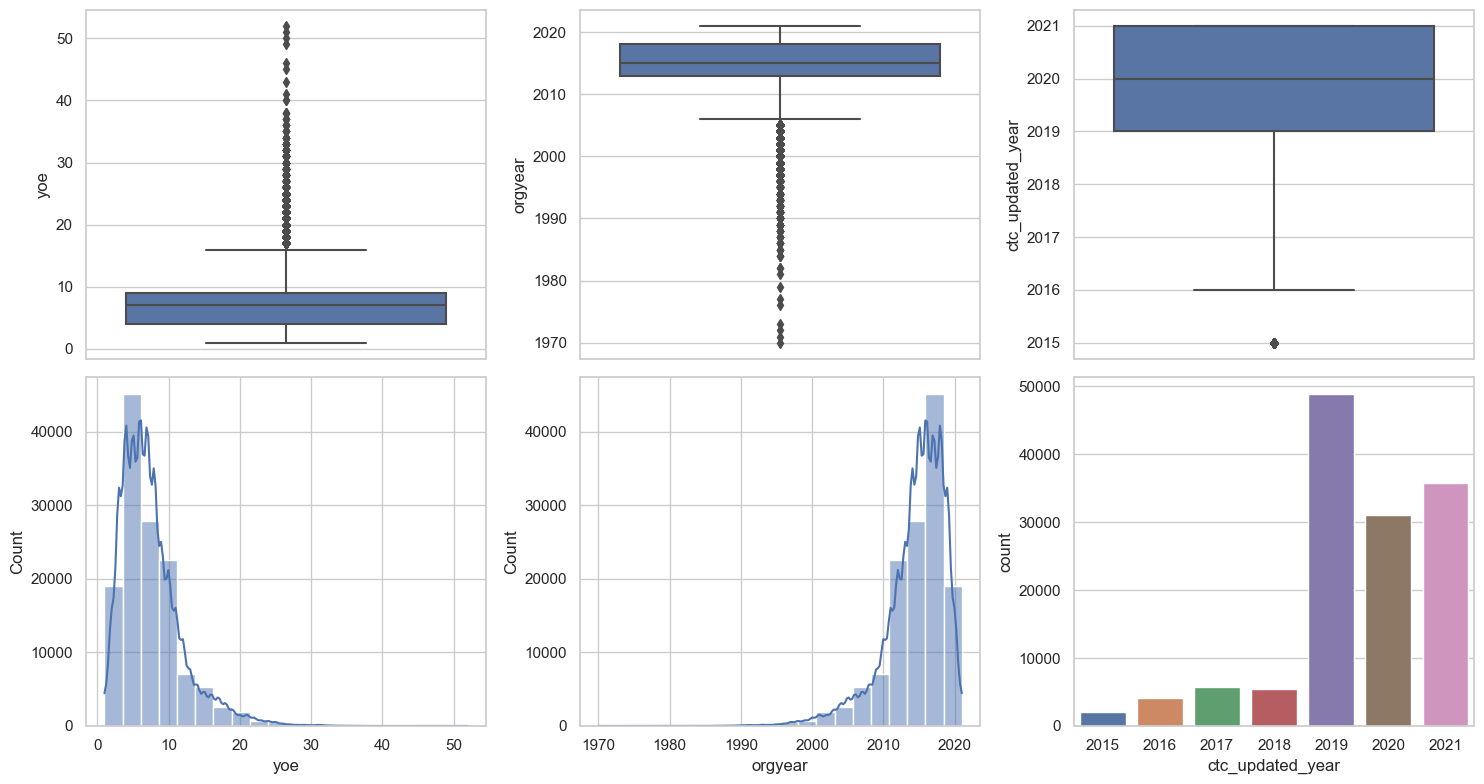

In [57]:
fig, ax = plt.subplots(2,3, figsize=(15, 8))
sns.boxplot(y=df["yoe"], ax=ax[0,0]);
sns.boxplot(y=df["orgyear"], ax=ax[0,1]);
sns.boxplot(y=df["ctc_updated_year"], ax=ax[0,2]);

sns.histplot(data=df.to_pandas(), x="yoe", kde=True, bins=20, ax=ax[1,0]);
sns.histplot(data=df.to_pandas(), x="orgyear",kde=True, bins=20, ax=ax[1,1]);
sns.countplot(data=df.to_pandas() ,x="ctc_updated_year", ax=ax[1,2]);

# plt.suptitle("Boxplot of Years of Experience, Organization Year and CTC Updated Year");
plt.tight_layout();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>



In [30]:
df["ctc"].quantile(0.95), df["ctc"].quantile(0.05)

(4000000.0, 200000.0)

In [28]:
ctc_filtered_df = df.filter((df["ctc"] < df["ctc"].quantile(0.95)) & (df["ctc"] > df["ctc"].quantile(0.05)))

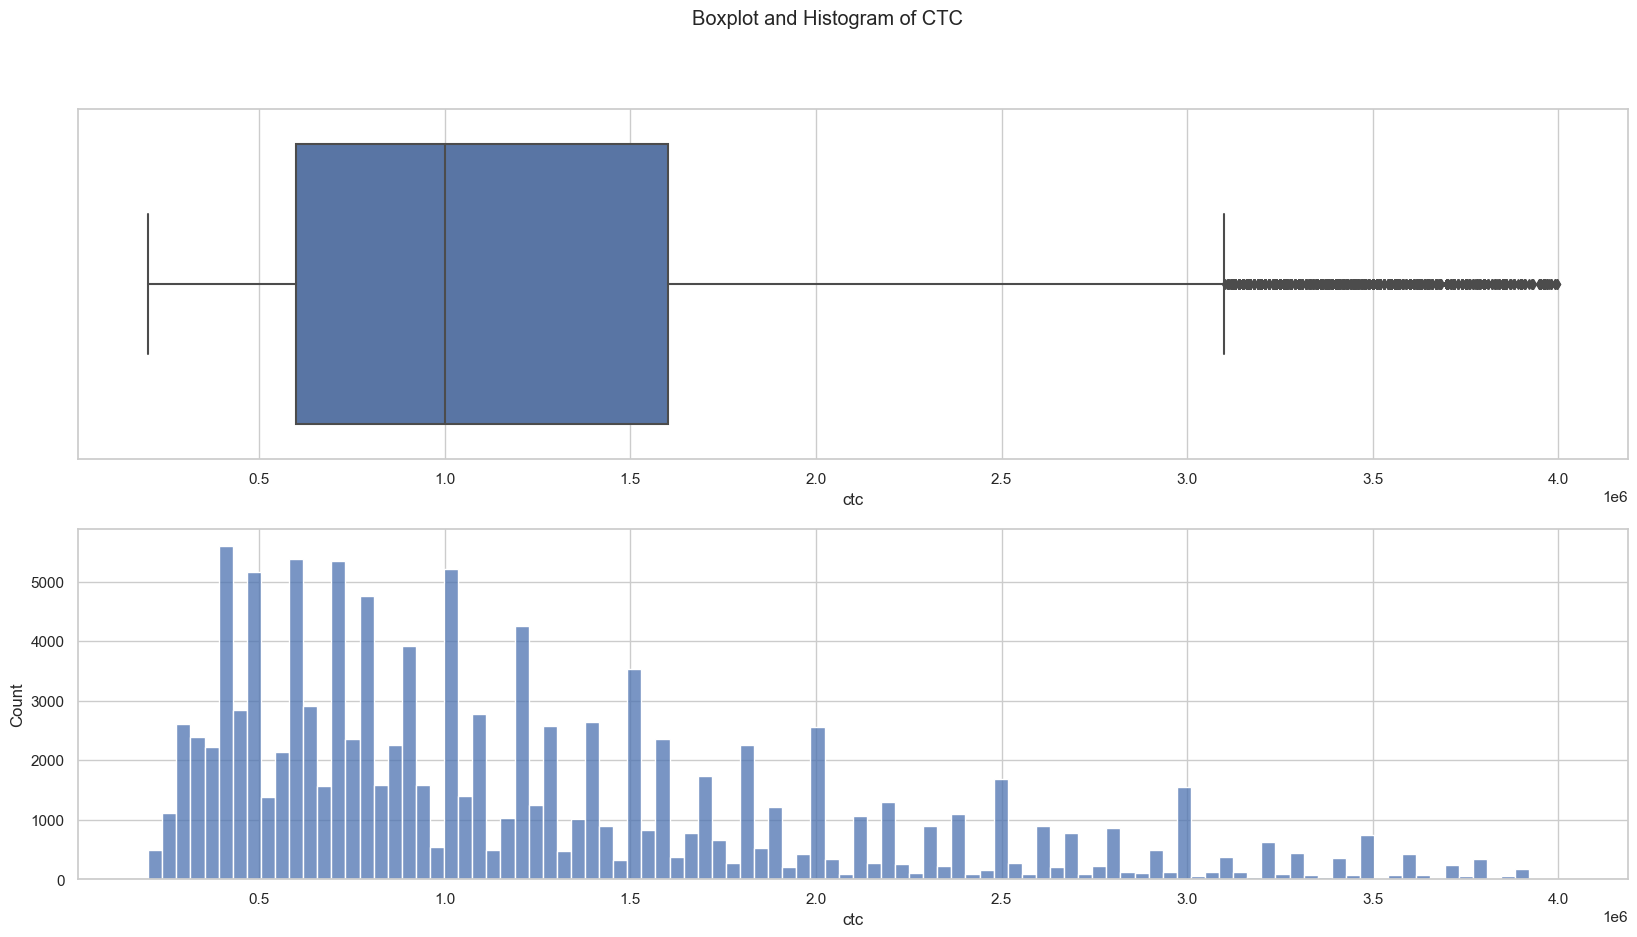

In [61]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
sns.boxplot(x=ctc_filtered_df["ctc"], ax=ax[0]);
sns.histplot(x=ctc_filtered_df["ctc"], ax=ax[1], bins=100);
plt.suptitle("Boxplot and Histogram of CTC");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above table we can see that the most of the CTCs are between 6 to 16 lakhs.

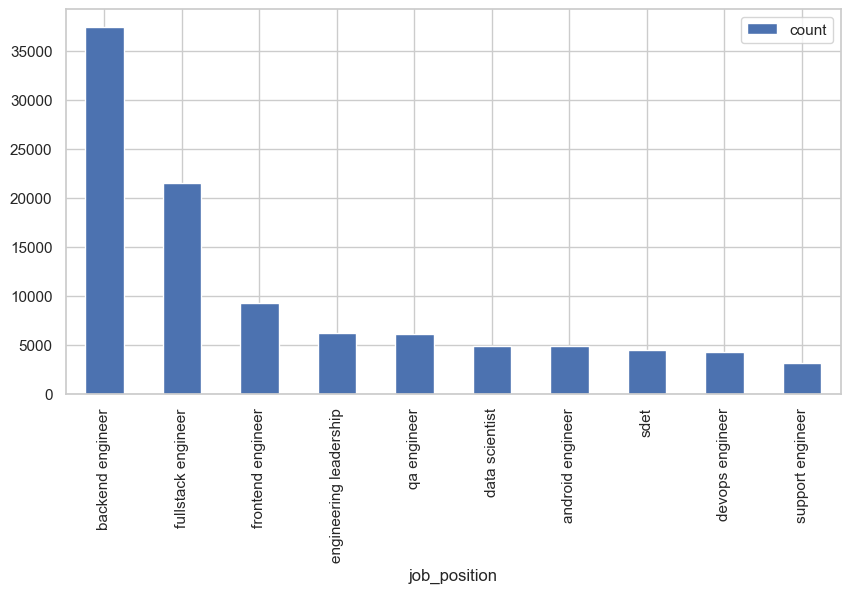

In [87]:
df.filter(df["job_position"]!="other")["job_position"].value_counts(sort=True).head(10).to_pandas().set_index("job_position").plot(kind="bar", figsize=(10, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>


**Average CTC of top 20 job positions**

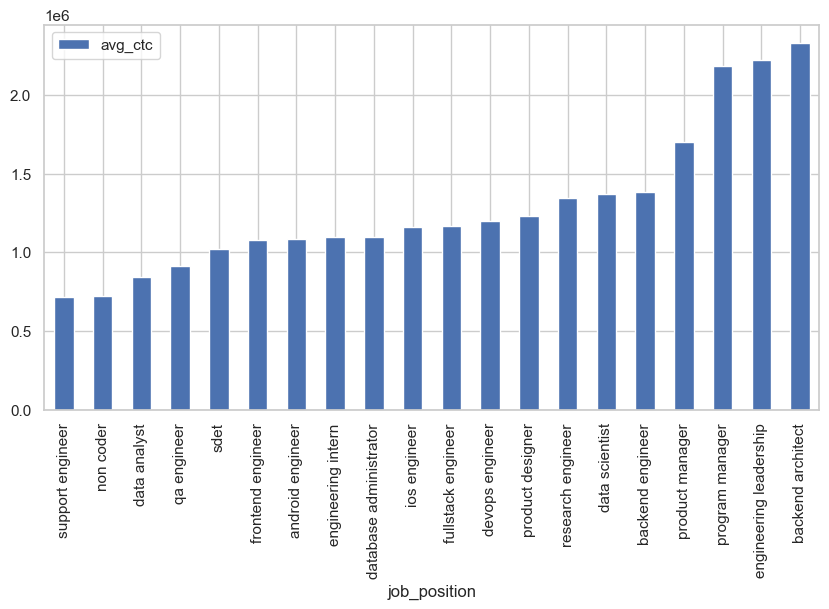

In [68]:
db.sql(""" 
    select job_position, avg(ctc) as avg_ctc from ctc_filtered_df where job_position <> 'other' group by job_position order by count(*) desc limit 20
""").to_df().sort_values(by="avg_ctc").set_index("job_position").plot(kind="bar", figsize=(10, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above is the plot of average ctc for top 20 popular job positions.
- We can see that backend architect has the highest average ctc.

In [29]:
db.sql(""" 
    select job_position, round(avg(yoe),0) as avg_yoe from ctc_filtered_df group by job_position order by count(*)  desc
""")

┌────────────────────────────────┬─────────┐
│          job_position          │ avg_yoe │
│            varchar             │ double  │
├────────────────────────────────┼─────────┤
│ backend engineer               │     7.0 │
│ fullstack engineer             │     6.0 │
│ other                          │     6.0 │
│ frontend engineer              │     7.0 │
│ qa engineer                    │     8.0 │
│ engineering leadership         │    13.0 │
│ android engineer               │     8.0 │
│ data scientist                 │     7.0 │
│ sdet                           │     8.0 │
│ devops engineer                │     9.0 │
│       ·                        │      ·  │
│       ·                        │      ·  │
│       ·                        │      ·  │
│ fibre engineer                 │    13.0 │
│ sub inspector                  │     8.0 │
│ erp consultant                 │     9.0 │
│ professional services engineer │     7.0 │
│ team lead mobile               │    10.0 │
│ service 

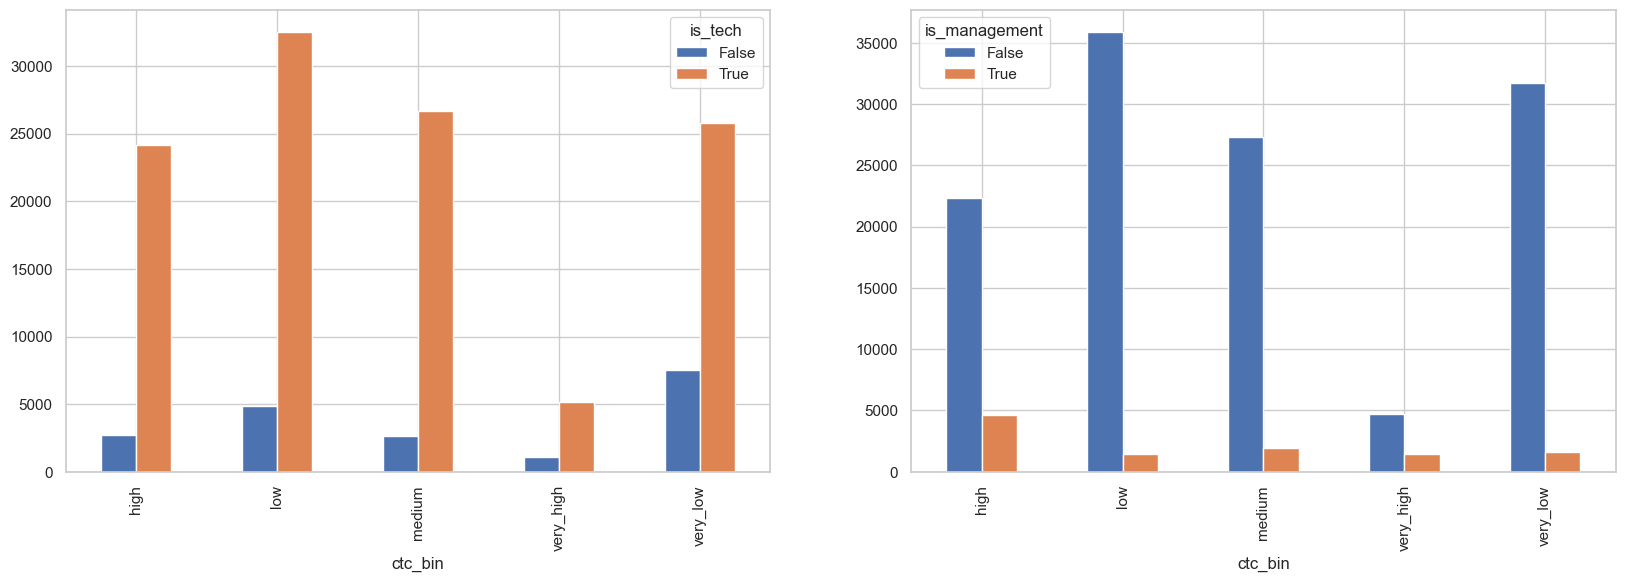

In [155]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
db.sql("""
    select ctc_bin, is_tech, count(*) as count from df group by ctc_bin, is_tech
""").to_df().pivot(index="ctc_bin", columns="is_tech", values="count").plot(kind="bar", ax=ax[0]);

db.sql("""
    select ctc_bin, is_management, count(*) as count from df group by ctc_bin, is_management
""").to_df().pivot(index="ctc_bin", columns="is_management", values="count").plot(kind="bar", ax=ax[1]);

In [73]:
tech_df = ctc_filtered_df.filter((ctc_filtered_df["is_tech"]) & (ctc_filtered_df["yoe"] < 20))
developer_df = ctc_filtered_df.filter((ctc_filtered_df["is_developer"]) & (ctc_filtered_df["yoe"] < 20))
management_df = ctc_filtered_df.filter((ctc_filtered_df["is_management"]) & (ctc_filtered_df["yoe"] < 40))
sales_df = ctc_filtered_df.filter((ctc_filtered_df["is_sales"]) & (ctc_filtered_df["yoe"] < 20))
non_coder_df = ctc_filtered_df.filter((ctc_filtered_df["is_non_coder"]) & (ctc_filtered_df["yoe"] < 20))

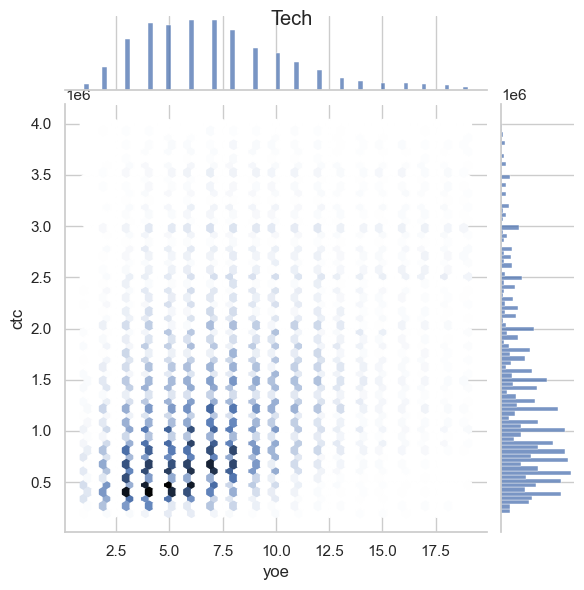

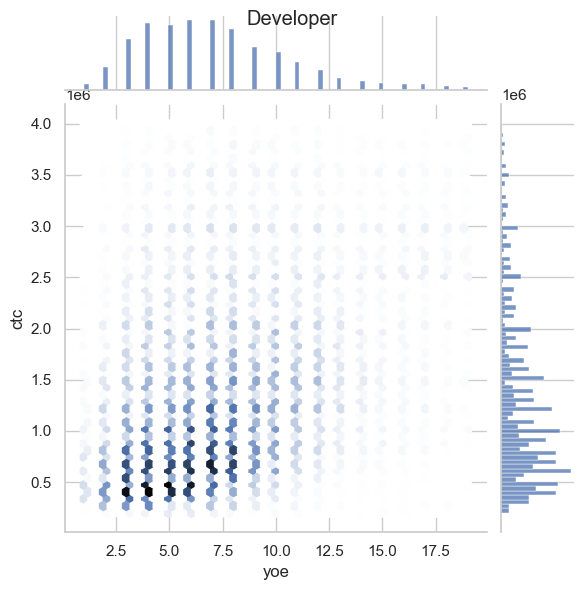

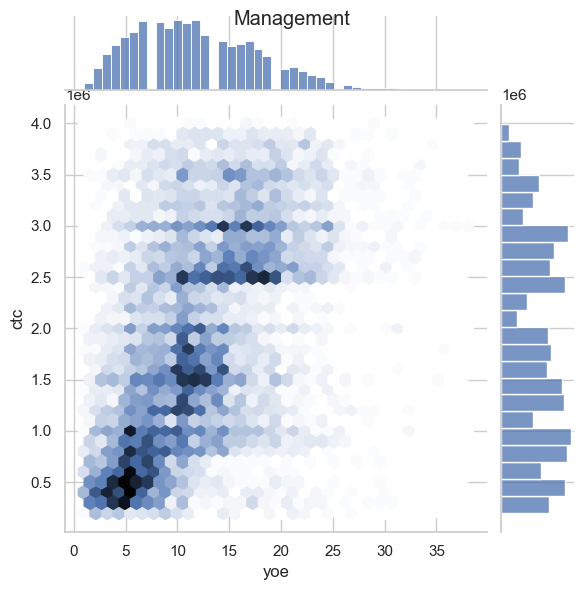

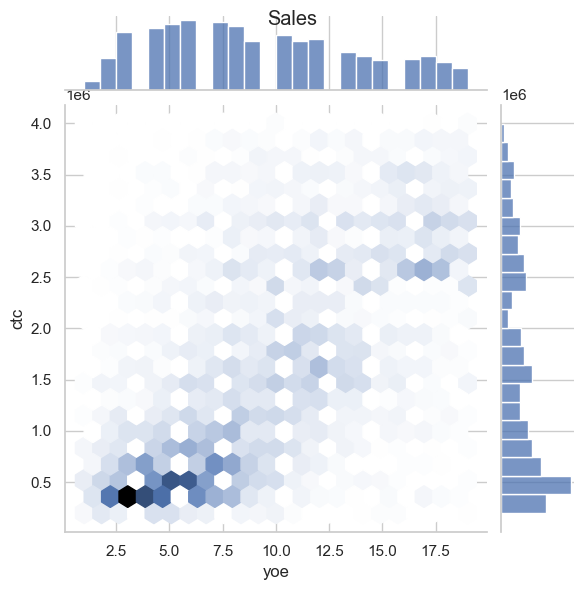

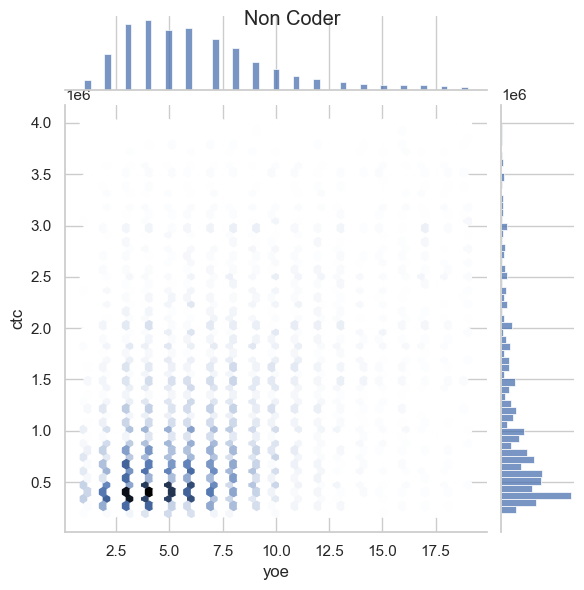

In [74]:
# fig, ax = plt.subplots(2,3, figsize=(20, 10))

sns.jointplot(tech_df["yoe"], tech_df["ctc"], kind="hex");
plt.suptitle("Tech");
sns.jointplot(developer_df["yoe"], developer_df["ctc"], kind="hex");
plt.suptitle("Developer");
sns.jointplot(management_df["yoe"], management_df["ctc"], kind="hex");
plt.suptitle("Management");
sns.jointplot(sales_df["yoe"], sales_df["ctc"], kind="hex");
plt.suptitle("Sales");
sns.jointplot(non_coder_df["yoe"], non_coder_df["ctc"], kind="hex");
plt.suptitle("Non Coder");


# Manual Clustering

In [78]:
df=pl.read_parquet("../data/processed/data.parquet")

In [79]:
df=df.drop(["email_hash","is_tech"])
df = df.with_columns(
    ctc_bin=pl.when(pl.col("ctc_bin") == "very_high").then(5)
    .when(pl.col("ctc_bin") == "high").then(4)
    .when(pl.col("ctc_bin") == "medium").then(3)
    .when(pl.col("ctc_bin") == "low").then(2)
    .otherwise(1)
)
job_frequency_df = df.group_by("job_position").agg(pl.count().alias("job_pos_frequency"))
df = df.join(job_frequency_df, on="job_position", how="left")
df=df.drop(["job_position"])
df=df.rename({"job_pos_frequency": "job_position"})
company_frequency_df = df.group_by("company_hash").agg(pl.count().alias("company_frequency"))
df = df.join(company_frequency_df, on="company_hash", how="left")
df=df.drop(["company_hash"])
df=df.rename({"company_frequency": "company_hash"})

In [80]:
df = df.with_columns(
    ctc=(df["ctc"] - df["ctc"].mean()) / df["ctc"].std(),
    yoe=(df["yoe"] - df["yoe"].mean()) / df["yoe"].std(),
    orgyear=(df["orgyear"] - df["orgyear"].mean()) / df["orgyear"].std(),
    ctc_updated_year=(df["ctc_updated_year"] - df["ctc_updated_year"].mean()) / df["ctc_updated_year"].std(),
    job_position=(df["job_position"] - df["job_position"].mean()) / df["job_position"].std(),
    ctc_bin=(df["ctc_bin"] - df["ctc_bin"].mean()) / df["ctc_bin"].std(),
    ctc_to_exp_ratio=(df["ctc_to_exp_ratio"] - df["ctc_to_exp_ratio"].mean()) / df["ctc_to_exp_ratio"].std(),
    growth=(df["growth"] - df["growth"].mean()) / df["growth"].std(),
    num_jobs=(df["num_jobs"] - df["num_jobs"].mean()) / df["num_jobs"].std(),
    company_hash=(df["company_hash"] - df["company_hash"].mean()) / df["company_hash"].std(),
)

df = df.with_columns(
    is_other=pl.col("is_other").cast(pl.Int32),
    is_developer=pl.col("is_developer").cast(pl.Int32),
    is_management=pl.col("is_management").cast(pl.Int32),
    is_non_coder=pl.col("is_non_coder").cast(pl.Int32),
    is_sales=pl.col("is_sales").cast(pl.Int32),
)

In [85]:
df = df.unique()
df

shape: (119_771, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ orgyear   ┆ ctc       ┆ ctc_updat ┆ yoe       ┆ … ┆ is_non_co ┆ ctc_bin   ┆ job_posit ┆ company_ │
│ ---       ┆ ---       ┆ ed_year   ┆ ---       ┆   ┆ der       ┆ ---       ┆ ion       ┆ hash     │
│ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆           ┆   ┆ i32       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.27299   ┆ -0.069908 ┆ 0.3798    ┆ -1.27299  ┆ … ┆ 0         ┆ 0.40634   ┆ -0.632186 ┆ 0.315777 │
│ 0.808337  ┆ -0.149511 ┆ -0.363565 ┆ -0.808337 ┆ … ┆ 0         ┆ -0.428769 ┆ -1.120752 ┆ -0.44777 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ 0.57601   ┆ -0.161451 ┆ -0.363565 ┆ -0.57601  ┆ … ┆ 0         ┆ -1.263878 ┆ 0.262518  ┆ 4.088932 │
│ -1.050274 ┆ -0.149511 ┆ -0.363565 ┆ 1.050274  ┆ … ┆ 0         ┆ -0.428769 ┆ -0.853597 ┆ -0.49025 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│ 0.111358  ┆ -0.139958 ┆ -0.363565 ┆ -0.111358 ┆ … ┆ 0         ┆ -0.428769 ┆ -0.862877 ┆ -0.46795 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 0.57601   ┆ -0.14155  ┆ 1.123165  ┆ -0.57601  ┆ … ┆ 0         ┆ -0.428769 ┆ 1.420651  ┆ -0.45520 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ -1.2826   ┆ -0.081849 ┆ -0.363565 ┆ 1.2826    ┆ … ┆ 0         ┆ 0.40634   ┆ -1.215966 ┆ -0.47113 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ -0.120969 ┆ -0.149511 ┆ 1.123165  ┆ 0.120969  ┆ … ┆ 1         ┆ -0.428769 ┆ -0.1643   ┆ -0.48069 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ -4.53517  ┆ 0.184819  ┆ -0.363565 ┆ 4.53517   ┆ … ┆ 0         ┆ 2.076557  ┆ -0.853597 ┆ -0.20564 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│ 0.111358  ┆ -0.085829 ┆ -0.363565 ┆ -0.111358 ┆ … ┆ 0         ┆ 0.40634   ┆ 1.420651  ┆ -0.48813 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [86]:
X=df.to_pandas()

In [89]:
X_embedded_pca = PCA(n_components=2).fit_transform(X.drop(["class_flag","designation_flag","tier_flag"], axis=1))

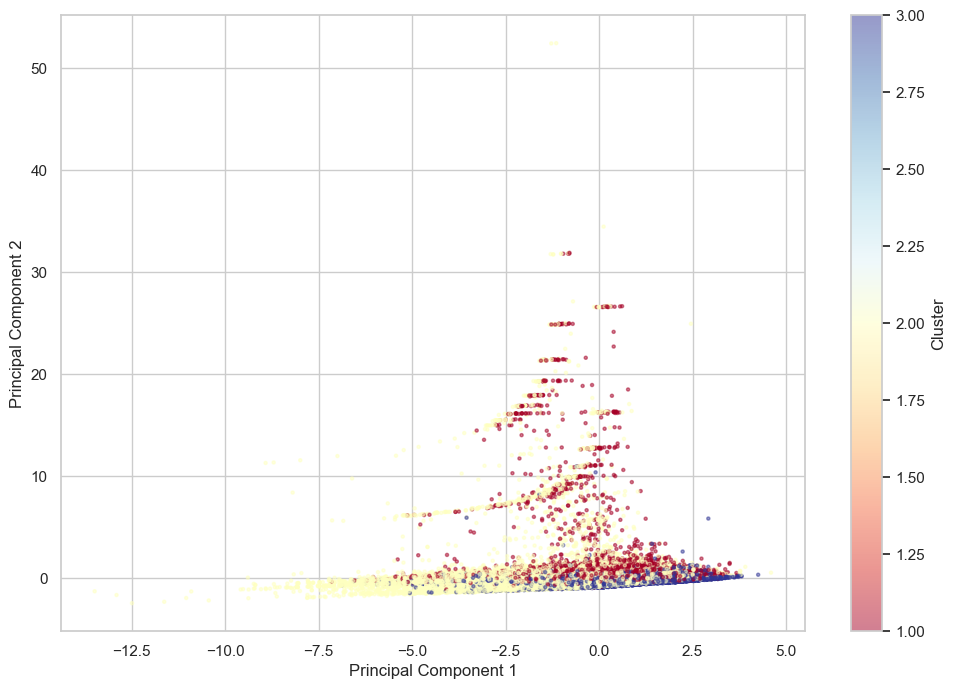

In [90]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["class_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

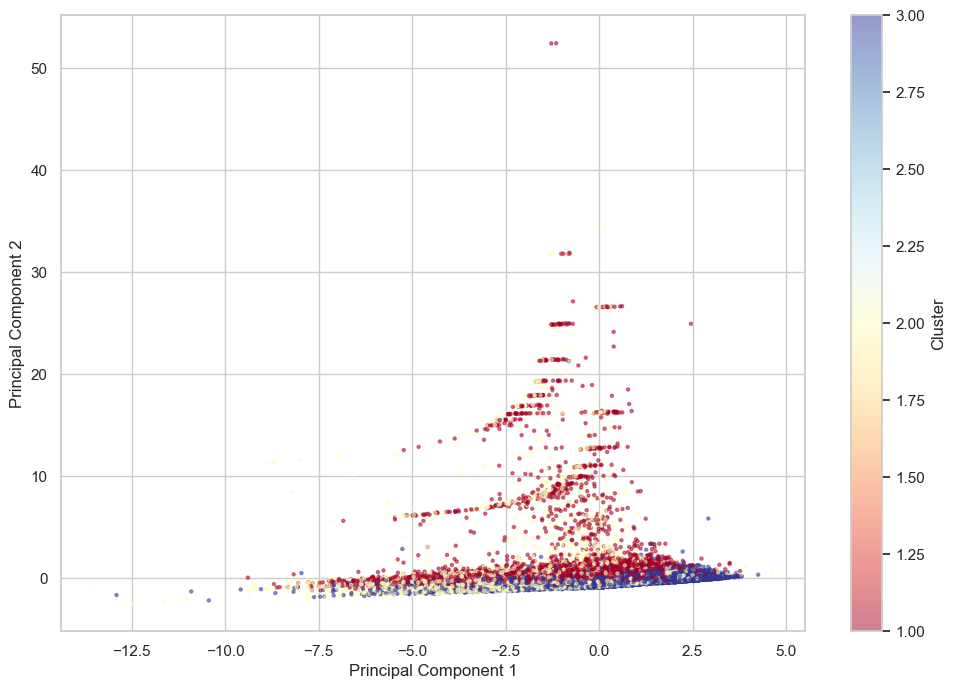

In [91]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["designation_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

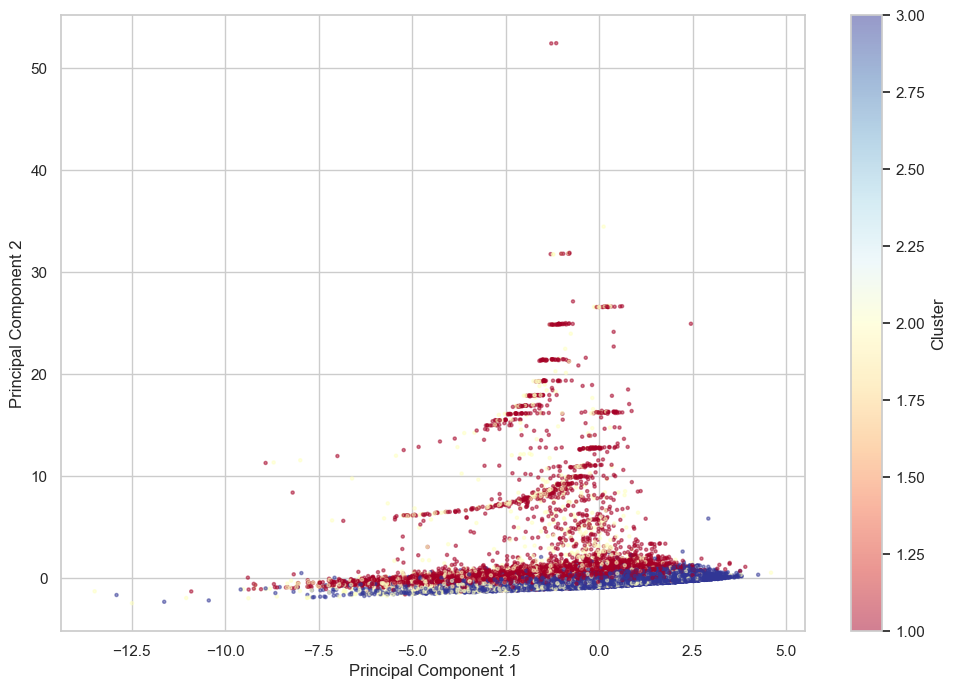

In [92]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=X["tier_flag"]  , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

* Top 10 employees (earning more than most of the employees in the company) - Tier 1
* Top 10 employees of data science in each company earning more than their peers - Class 1
* Bottom 10 employees of data science in each company earning less than their peers - Class 3
* Bottom 10 employees (earning less than most of the employees in the company)- Tier 3
* Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X
* Top 10 companies (based on their CTC)
* Top 2 positions in every company (based on their CTC)

In [72]:
df.filter(pl.col("tier_flag") == 1).sort("ctc", descending=True).limit(10)

shape: (10, 20)
┌────────────┬────────────┬───────────┬─────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ company_ha ┆ job_positi ┆ email_has ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin   │
│ sh         ┆ on         ┆ h         ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str       │
│ str        ┆ str        ┆ str       ┆         ┆   ┆ bool      ┆          ┆ bool      ┆           │
╞════════════╪════════════╪═══════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ qtrxvzwt   ┆ data       ┆ f1b31a501 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ xzegwgbb   ┆ analyst    ┆ f6b7fd6ed ┆         ┆   ┆           ┆          ┆           ┆           │
│ rxbxnta    ┆            ┆ ae9e7e883 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ bf6…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ otre       ┆ android    ┆ f63e63a8c ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ tburgjta   ┆ engineer   ┆ c3db37c89 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ a49f0498d ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 073…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv sqghu ┆ other      ┆ 3a5fc9df8 ┆ 2013    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│            ┆            ┆ 19bcc49b5 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 20771ae2f ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ cb9…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ xb  v      ┆ fullstack  ┆ 431c610cf ┆ 2018    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ onhatzn    ┆ engineer   ┆ fb5f69947 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 6173431bb ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 1f4…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ ftrro      ┆ support    ┆ 54bafd5fc ┆ 2015    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│ evqsg      ┆ engineer   ┆ 688d31915 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 438560bd4 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ e94…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ vrnqvz     ┆ other      ┆ 643caeb3a ┆ 2014    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│            ┆            ┆ 1b6e1cbba ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 8cb026833 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 609…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvrtza     ┆ support    ┆ 6b3c27564 ┆ 2016    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│            ┆ engineer   ┆ 3094c663a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 51e84196f ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ d71…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ otre       ┆ other      ┆ 4f83774df ┆ 2020    ┆ … ┆ false     ┆ false    ┆ true      ┆ very_high │
│ tburgjta   ┆            ┆ e4b97bfd0 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 836463f3a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 573…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ support    ┆ 199146d59 ┆ 2017    ┆ … ┆ false     ┆ true     ┆ false     ┆ very_high │
│ rnvzwj     ┆ engineer   ┆ 076620fa9 ┆      

In [89]:
db.sql("""
select * from df where job_position like 'data %' and class_flag = 1 and tier_flag = 1 order by ctc desc limit 10
""").pl()

shape: (10, 20)
┌────────────┬────────────┬───────────┬─────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ company_ha ┆ job_positi ┆ email_has ┆ orgyear ┆ … ┆ is_manage ┆ is_sales ┆ is_non_co ┆ ctc_bin   │
│ sh         ┆ on         ┆ h         ┆ ---     ┆   ┆ ment      ┆ ---      ┆ der       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ i32     ┆   ┆ ---       ┆ bool     ┆ ---       ┆ str       │
│ str        ┆ str        ┆ str       ┆         ┆   ┆ bool      ┆          ┆ bool      ┆           │
╞════════════╪════════════╪═══════════╪═════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ nvnv wgzoh ┆ data       ┆ d42cf076c ┆ 2012    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rnvzwj     ┆ analyst    ┆ 3915454a0 ┆         ┆   ┆           ┆          ┆           ┆           │
│ otqcxwto   ┆            ┆ 83788ea22 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ df6…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ ytfrtnn    ┆ data       ┆ c888824e6 ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ uvwpvqa    ┆ analyst    ┆ 87a535d1b ┆         ┆   ┆           ┆          ┆           ┆           │
│ tzntquqxot ┆            ┆ d2486ae28 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ d67…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ zgzt       ┆ data       ┆ 268a5aa92 ┆ 2019    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ scientist  ┆ f0b6d0c67 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 5fc9cc1e3 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 00e…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ data       ┆ 655da5cd9 ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rnvzwj     ┆ analyst    ┆ 9f1ba4ad2 ┆         ┆   ┆           ┆          ┆           ┆           │
│ otqcxwto   ┆            ┆ 49dade503 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 9b9…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ wgzahtzn   ┆ data       ┆ 9ce2995b2 ┆ 2016    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 221fe627e ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 861daea9d ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 060…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ nvnv wgzoh ┆ data       ┆ 59316048d ┆ 2015    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│ rnvzwj     ┆ analyst    ┆ 113539202 ┆         ┆   ┆           ┆          ┆           ┆           │
│ otqcxwto   ┆            ┆ 325e05af9 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ b66…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ vwwtznhqt  ┆ data       ┆ 2f9a42410 ┆ 2016    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 53f76b2f8 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ c50ea593a ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 905…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ wgszxkvzn  ┆ data       ┆ aad581a53 ┆ 2014    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 2f319c76c ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 6e7393757 ┆         ┆   ┆           ┆          ┆           ┆           │
│            ┆            ┆ 2fe…      ┆         ┆   ┆           ┆          ┆           ┆           │
│ gnytq      ┆ data       ┆ 6d4a5d19e ┆ 2017    ┆ … ┆ false     ┆ false    ┆ false     ┆ very_high │
│            ┆ analyst    ┆ 889596252 ┆      

# Standardization & Encoding

In [52]:
df=pl.read_parquet("../data/processed/data.parquet")

In [53]:
df=df.drop(["email_hash", "class_flag", "designation_flag", "tier_flag","company_hash", "is_tech"])

In [54]:
df

shape: (133_146, 14)
┌─────────────┬─────────┬─────────┬────────────┬───┬────────────┬──────────┬────────────┬──────────┐
│ job_positio ┆ orgyear ┆ ctc     ┆ ctc_update ┆ … ┆ is_managem ┆ is_sales ┆ is_non_cod ┆ ctc_bin  │
│ n           ┆ ---     ┆ ---     ┆ d_year     ┆   ┆ ent        ┆ ---      ┆ er         ┆ ---      │
│ ---         ┆ i32     ┆ i64     ┆ ---        ┆   ┆ ---        ┆ bool     ┆ ---        ┆ str      │
│ str         ┆         ┆         ┆ i32        ┆   ┆ bool       ┆          ┆ bool       ┆          │
╞═════════════╪═════════╪═════════╪════════════╪═══╪════════════╪══════════╪════════════╪══════════╡
│ data        ┆ 2014    ┆ 950000  ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ analyst     ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ backend     ┆ 2015    ┆ 420000  ┆ 2016       ┆ … ┆ false      ┆ false    ┆ false      ┆ very_low │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ data        ┆ 2017    ┆ 1800000 ┆ 2019       ┆ … ┆ false      ┆ false    ┆ false      ┆ high     │
│ scientist   ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ fullstack   ┆ 2017    ┆ 700000  ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ backend     ┆ 2013    ┆ 1000000 ┆ 2016       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ …           ┆ …       ┆ …       ┆ …          ┆ … ┆ …          ┆ …        ┆ …          ┆ …        │
│ sdet        ┆ 2014    ┆ 600000  ┆ 2019       ┆ … ┆ false      ┆ false    ┆ false      ┆ low      │
│ support     ┆ 2016    ┆ 220000  ┆ 2019       ┆ … ┆ false      ┆ true     ┆ false      ┆ very_low │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ other       ┆ 2005    ┆ 2500000 ┆ 2021       ┆ … ┆ false      ┆ false    ┆ true       ┆ high     │
│ android     ┆ 2019    ┆ 1050000 ┆ 2020       ┆ … ┆ false      ┆ false    ┆ false      ┆ medium   │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
│ android     ┆ 2019    ┆ 1200000 ┆ 2021       ┆ … ┆ false      ┆ false    ┆ false      ┆ medium   │
│ engineer    ┆         ┆         ┆            ┆   ┆            ┆          ┆            ┆          │
└─────────────┴─────────┴─────────┴────────────┴───┴────────────┴──────────┴────────────┴──────────┘

In [55]:
df = df.with_columns(
    ctc_bin=pl.when(pl.col("ctc_bin") == "very_high").then(5)
    .when(pl.col("ctc_bin") == "high").then(4)
    .when(pl.col("ctc_bin") == "medium").then(3)
    .when(pl.col("ctc_bin") == "low").then(2)
    .otherwise(1)
)

In [56]:
job_frequency_df = df.group_by("job_position").agg(pl.count().alias("job_pos_frequency"))
df = df.join(job_frequency_df, on="job_position", how="left")
df=df.drop(["job_position"])
df=df.rename({"job_pos_frequency": "job_position"})

In [57]:
# company_frequency_df = df.group_by("company_hash").agg(pl.count().alias("company_frequency"))
# df = df.join(company_frequency_df, on="company_hash", how="left")
# df=df.drop(["company_hash"])
# df=df.rename({"company_frequency": "company_hash"})

In [58]:
df

shape: (133_146, 14)
┌─────────┬─────────┬─────────────────┬─────┬───┬──────────┬──────────────┬─────────┬──────────────┐
│ orgyear ┆ ctc     ┆ ctc_updated_yea ┆ yoe ┆ … ┆ is_sales ┆ is_non_coder ┆ ctc_bin ┆ job_position │
│ ---     ┆ ---     ┆ r               ┆ --- ┆   ┆ ---      ┆ ---          ┆ ---     ┆ ---          │
│ i32     ┆ i64     ┆ ---             ┆ i32 ┆   ┆ bool     ┆ bool         ┆ i32     ┆ u32          │
│         ┆         ┆ i32             ┆     ┆   ┆          ┆              ┆         ┆              │
╞═════════╪═════════╪═════════════════╪═════╪═══╪══════════╪══════════════╪═════════╪══════════════╡
│ 2014    ┆ 950000  ┆ 2021            ┆ 8   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 2574         │
│ 2015    ┆ 420000  ┆ 2016            ┆ 7   ┆ … ┆ false    ┆ false        ┆ 1       ┆ 37353        │
│ 2017    ┆ 1800000 ┆ 2019            ┆ 5   ┆ … ┆ false    ┆ false        ┆ 4       ┆ 4876         │
│ 2017    ┆ 700000  ┆ 2021            ┆ 5   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 21504        │
│ 2013    ┆ 1000000 ┆ 2016            ┆ 9   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 37353        │
│ …       ┆ …       ┆ …               ┆ …   ┆ … ┆ …        ┆ …            ┆ …       ┆ …            │
│ 2014    ┆ 600000  ┆ 2019            ┆ 8   ┆ … ┆ false    ┆ false        ┆ 2       ┆ 4541         │
│ 2016    ┆ 220000  ┆ 2019            ┆ 6   ┆ … ┆ true     ┆ false        ┆ 1       ┆ 3158         │
│ 2005    ┆ 2500000 ┆ 2021            ┆ 17  ┆ … ┆ false    ┆ true         ┆ 4       ┆ 15663        │
│ 2019    ┆ 1050000 ┆ 2020            ┆ 3   ┆ … ┆ false    ┆ false        ┆ 3       ┆ 4876         │
│ 2019    ┆ 1200000 ┆ 2021            ┆ 3   ┆ … ┆ false    ┆ false        ┆ 3       ┆ 4876         │
└─────────┴─────────┴─────────────────┴─────┴───┴──────────┴──────────────┴─────────┴──────────────┘

In [60]:

# standardize the data
df = df.with_columns(
    ctc=(df["ctc"] - df["ctc"].mean()) / df["ctc"].std(),
    yoe=(df["yoe"] - df["yoe"].mean()) / df["yoe"].std(),
    orgyear=(df["orgyear"] - df["orgyear"].mean()) / df["orgyear"].std(),
    ctc_updated_year=(df["ctc_updated_year"] - df["ctc_updated_year"].mean()) / df["ctc_updated_year"].std(),
    job_position=(df["job_position"] - df["job_position"].mean()) / df["job_position"].std(),
    ctc_bin=(df["ctc_bin"] - df["ctc_bin"].mean()) / df["ctc_bin"].std(),
    # class_flag=(df["class_flag"] - df["class_flag"].mean()) / df["class_flag"].std(),
    # designation_flag=(df["designation_flag"] - df["designation_flag"].mean()) / df["designation_flag"].std(),
    # tier_flag=(df["tier_flag"] - df["tier_flag"].mean()) / df["tier_flag"].std(),
    ctc_to_exp_ratio=(df["ctc_to_exp_ratio"] - df["ctc_to_exp_ratio"].mean()) / df["ctc_to_exp_ratio"].std(),
    growth=(df["growth"] - df["growth"].mean()) / df["growth"].std(),
    num_jobs=(df["num_jobs"] - df["num_jobs"].mean()) / df["num_jobs"].std(),
    # company_hash=(df["company_hash"] - df["company_hash"].mean()) / df["company_hash"].std(),
)

df = df.with_columns(
    is_other=pl.col("is_other").cast(pl.Int32),
    # is_tech=pl.col("is_tech").cast(pl.Int32),
    is_developer=pl.col("is_developer").cast(pl.Int32),
    is_management=pl.col("is_management").cast(pl.Int32),
    is_non_coder=pl.col("is_non_coder").cast(pl.Int32),
    is_sales=pl.col("is_sales").cast(pl.Int32),
)

In [84]:
df=df.unique()

In [62]:
df

shape: (68_185, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ orgyear   ┆ ctc       ┆ ctc_updat ┆ yoe       ┆ … ┆ is_sales ┆ is_non_co ┆ ctc_bin   ┆ job_posit │
│ ---       ┆ ---       ┆ ed_year   ┆ ---       ┆   ┆ ---      ┆ der       ┆ ---       ┆ ion       │
│ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ i32      ┆ ---       ┆ f64       ┆ ---       │
│           ┆           ┆ f64       ┆           ┆   ┆          ┆ i32       ┆           ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ -1.747253 ┆ 0.017654  ┆ 0.3798    ┆ 1.747253  ┆ … ┆ 0        ┆ 0         ┆ 1.241448  ┆ 0.262518  │
│ -0.817948 ┆ 0.192779  ┆ 1.123165  ┆ 0.817948  ┆ … ┆ 0        ┆ 0         ┆ 2.076557  ┆ -1.231019 │
│ 0.57601   ┆ -0.10971  ┆ 0.3798    ┆ -0.57601  ┆ … ┆ 0        ┆ 0         ┆ 0.40634   ┆ -0.952538 │
│ -1.050274 ┆ 0.041535  ┆ 1.123165  ┆ 1.050274  ┆ … ┆ 0        ┆ 1         ┆ 1.241448  ┆ -0.1643   │
│ -1.050274 ┆ -0.174187 ┆ -0.363565 ┆ 1.050274  ┆ … ┆ 0        ┆ 0         ┆ -1.263878 ┆ -0.952538 │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …        ┆ …         ┆ …         ┆ …         │
│ 0.57601   ┆ -0.173391 ┆ 0.3798    ┆ -0.57601  ┆ … ┆ 0        ┆ 0         ┆ -1.263878 ┆ -0.862877 │
│ -0.585621 ┆ -0.145531 ┆ -0.363565 ┆ 0.585621  ┆ … ┆ 0        ┆ 0         ┆ -0.428769 ┆ -0.977017 │
│ -0.585621 ┆ -0.139958 ┆ -1.850294 ┆ 0.585621  ┆ … ┆ 0        ┆ 0         ┆ -0.428769 ┆ -1.308695 │
│ 0.57601   ┆ 0.081336  ┆ -1.106929 ┆ -0.57601  ┆ … ┆ 0        ┆ 0         ┆ 1.241448  ┆ 1.420651  │
│ 0.111358  ┆ -0.105729 ┆ 0.3798    ┆ -0.111358 ┆ … ┆ 0        ┆ 0         ┆ 0.40634   ┆ -0.632186 │
└───────────┴───────────┴───────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [214]:
corr=df.to_pandas().corr()

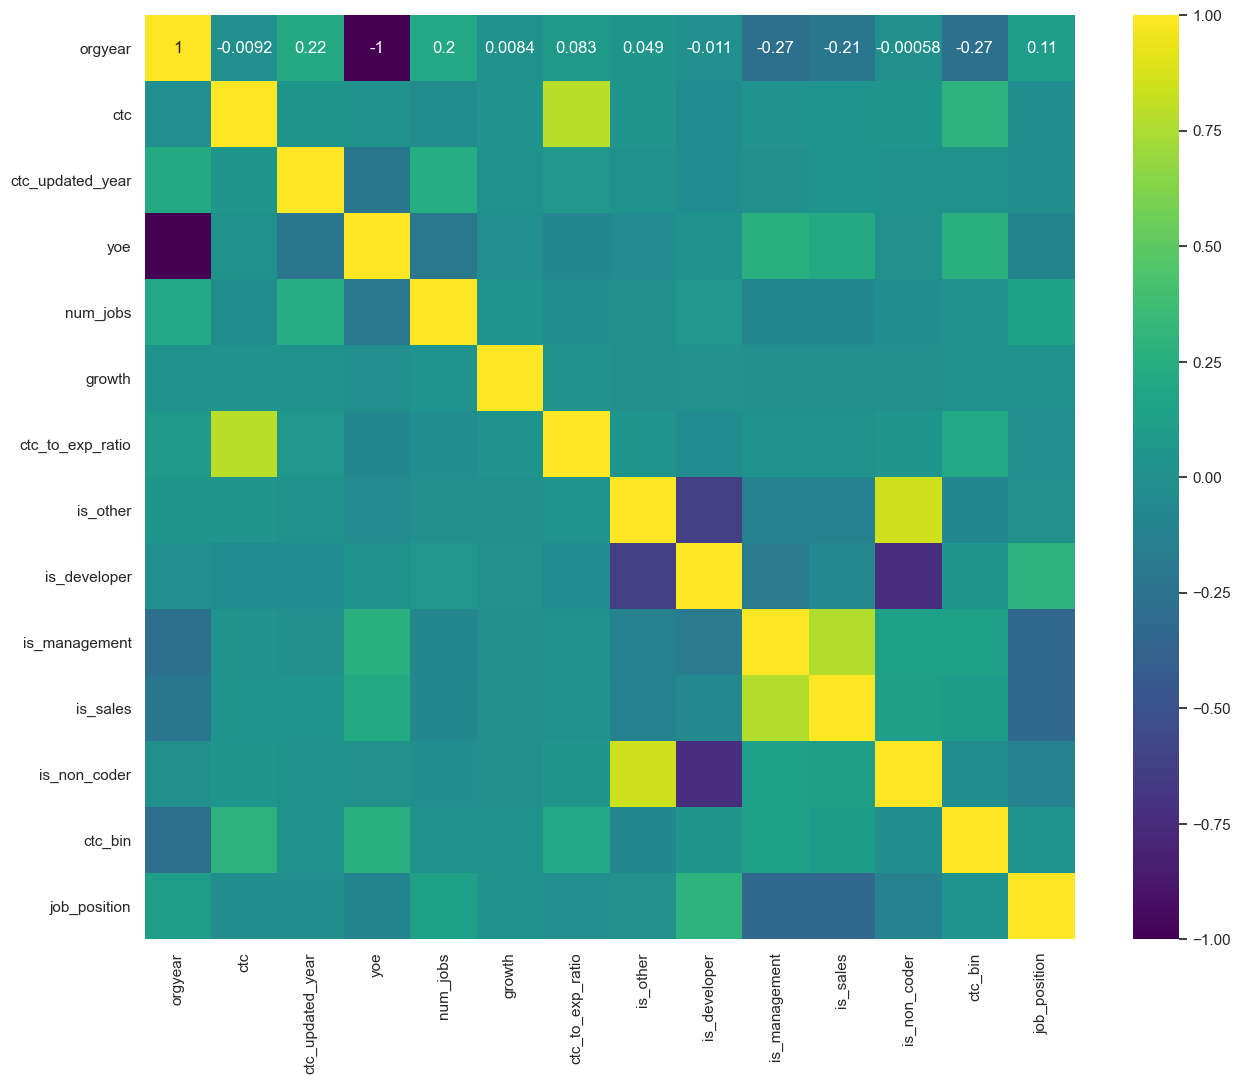

In [215]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="viridis", annot=True);

**Remove outliers using Local Outlier Factor**

In [63]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05).fit_predict(df.to_pandas())

In [64]:
df = df.with_columns(is_inlier=clf)
df["is_inlier"].value_counts()
df=df.filter(df["is_inlier"] == 1)

shape: (2, 2)
┌───────────┬───────┐
│ is_inlier ┆ count │
│ ---       ┆ ---   │
│ i64       ┆ u32   │
╞═══════════╪═══════╡
│ -1        ┆ 3410  │
│ 1         ┆ 64775 │
└───────────┴───────┘

In [65]:
X = df.to_pandas().drop(["is_inlier"], axis=1)

In [219]:
df.write_parquet("../data/processed/data_scaled.parquet")
X.to_parquet("../data/processed/X.parquet")

In [2]:
df=pl.read_parquet("../data/processed/data_scaled.parquet")
X=pd.read_parquet("../data/processed/X.parquet")

# Unsupervised Learning

**Hopkins Test to check the cluster tendency**

In [220]:
def hopkins_statistic(X, sample_size=0.1):
    n = X.shape[0] 
    m = int(sample_size * n) 

    random_indices = np.random.choice(np.arange(n), size=m, replace=False)
    X_sample = X.iloc[random_indices]

    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_uniform_random = np.random.uniform(X_min, X_max, (m, X.shape[1]))

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)

    u_distances, _ = nbrs.kneighbors(X_sample)
    u_distances = u_distances.sum()
    w_distances, _ = nbrs.kneighbors(X_uniform_random)
    w_distances = w_distances.sum()

    hopkins_stat = w_distances / (u_distances + w_distances)

    return hopkins_stat

In [221]:
hopkins_stat = hopkins_statistic(X)
print(f"Hopkins Statistic: {hopkins_stat}")

Hopkins Statistic: 1.0


## K-Means Clustering

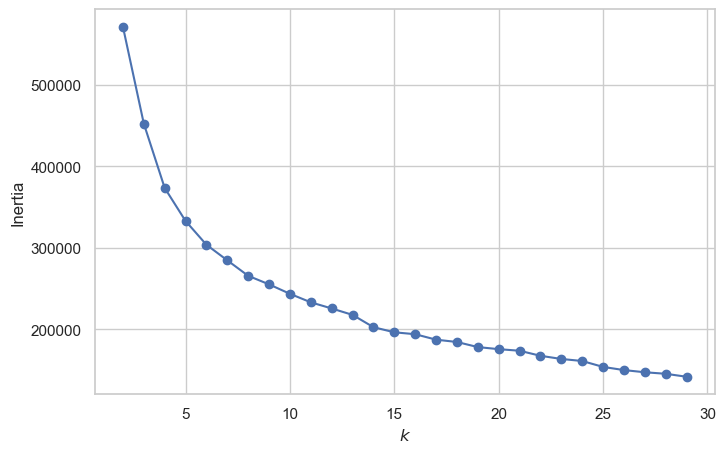

In [222]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(2, 30, 1)]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(range(2, 30, 1), inertias, "-o")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show();

**Using PCA to reduce the dimensions**

In [223]:
pca_explained_variance = PCA().fit(X).explained_variance_ratio_.cumsum()
pca_explained_variance

array([0.28207368, 0.48866291, 0.64811405, 0.75366195, 0.84304101,
       0.91929074, 0.94826786, 0.96800794, 0.98302944, 0.99222173,
       0.9969669 , 0.99893238, 1.        , 1.        ])

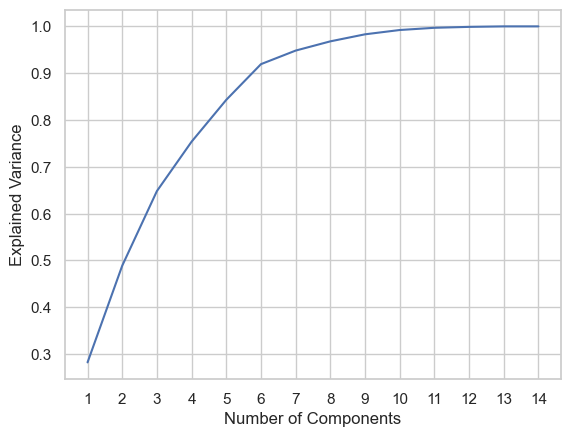

In [224]:
sns.lineplot(x=range(1, len(pca_explained_variance) + 1), y=pca_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

plt.xticks(range(1, len(pca_explained_variance) + 1))
plt.show();

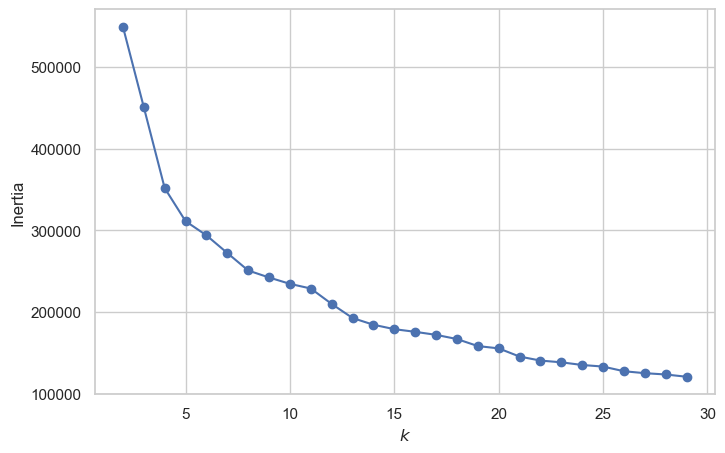

In [225]:
X_embedded_pca = PCA(n_components=8).fit_transform(X)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_embedded_pca)
                for k in range(2, 30, 1)]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 5))
plt.plot(range(2, 30, 1), inertias, "-o")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

From above plot we are not able to find the optimal number of clusters. But since there seems to be a slight elbow at 5, we can consider 5 clusters.

In [226]:
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_embedded_pca)
df=df.with_columns(
    y_kmeans=y_kmeans
)

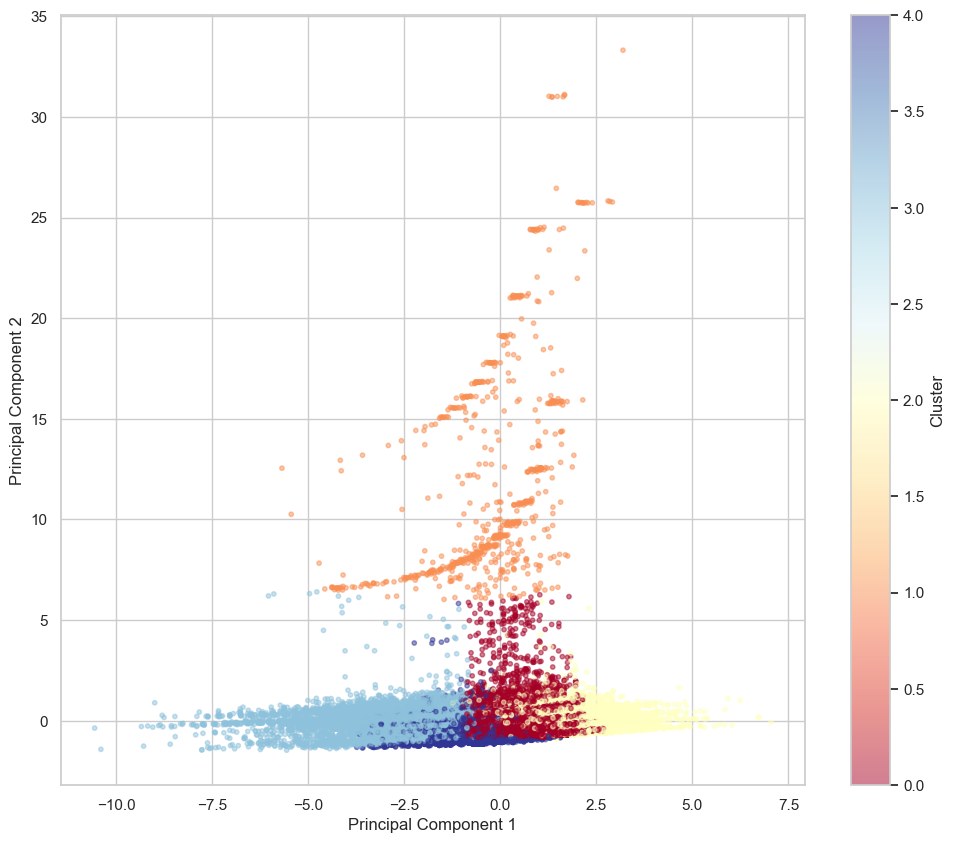

In [227]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(X_embedded_pca[:, 0], X_embedded_pca[:, 1], c=y_kmeans, s=10, cmap='RdYlBu', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above clustering plot, we can see there is similarity between plaot generated by manual clustering and k-means clustering.

In [21]:
def create_polar_plot(data, features, cluster_label):
    num_vars = len(features)

    # Compute angle of each axis (in radians)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made in a circular (polar) form, so we need to "close the loop"
    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title(f'Cluster {cluster_label}', size=20, color='blue', y=1.1)

    plt.show();

def create_combined_polar_plot(normalized_means, features, cluster_labels):
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

    for i, data in enumerate(normalized_means):
        data = np.concatenate((data, [data[0]]))
        ax.fill(angles, data, alpha=0.25, label=f'Cluster {cluster_labels[i]}')
        ax.plot(angles, data, linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    plt.title('Cluster Comparison', size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()



In [229]:
cluster_means = df.group_by("y_kmeans").mean().to_pandas().drop(["y_kmeans","is_inlier"], axis=1)

scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(cluster_means)

In [230]:
cluster_means

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
0 -0.327516 -0.089385         -1.855684  0.327516 -0.216063 -0.012841   
1  0.376624 -0.069102          0.302020 -0.376624 -0.339155 -0.013919   
2  0.390229 -0.069585          0.562197 -0.390229  2.549371  0.065804   
3  0.120952  9.461221          0.444488 -0.120952 -0.258959 -0.005299   
4 -1.918170  0.018687         -0.138136  1.918170 -0.209353 -0.010262   

   ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
0         -0.092348  0.107654      0.827551       0.059655  0.057636   
1         -0.038127  0.111660      0.740836       0.095240  0.111131   
2         -0.046173  0.100049      0.828030       0.047318  0.067492   
3          7.738631  0.231563      0.597345       0.168142  0.196165   
4         -0.084150  0.076208      0.757585       0.296871  0.272362   

   is_non_coder   ctc_bin  job_position  
0      0.127111 -0.045168      0.197273  
1      0.146267 -0.081313     -0.290874  
2      0.114401  0.185543      0.132658  
3      0.299410  2.076557     -0.383857  
4      0.144535  0.806881     -0.483044

In [231]:
cluster_means.columns.to_list()

['orgyear',
 'ctc',
 'ctc_updated_year',
 'yoe',
 'num_jobs',
 'growth',
 'ctc_to_exp_ratio',
 'is_other',
 'is_developer',
 'is_management',
 'is_sales',
 'is_non_coder',
 'ctc_bin',
 'job_position']

In [233]:
features =cluster_means.columns.to_list()

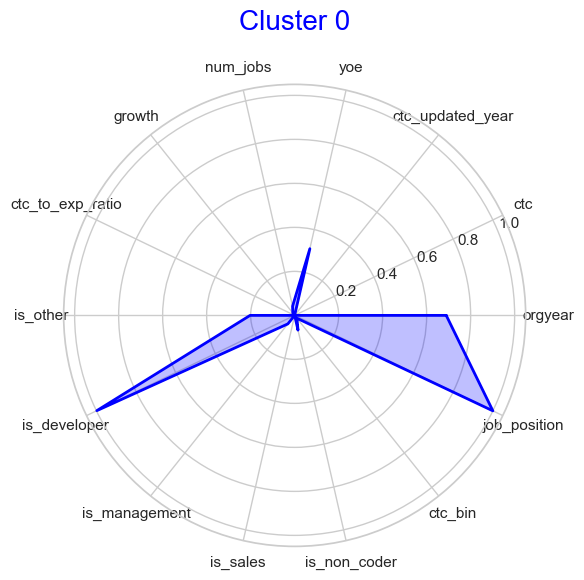

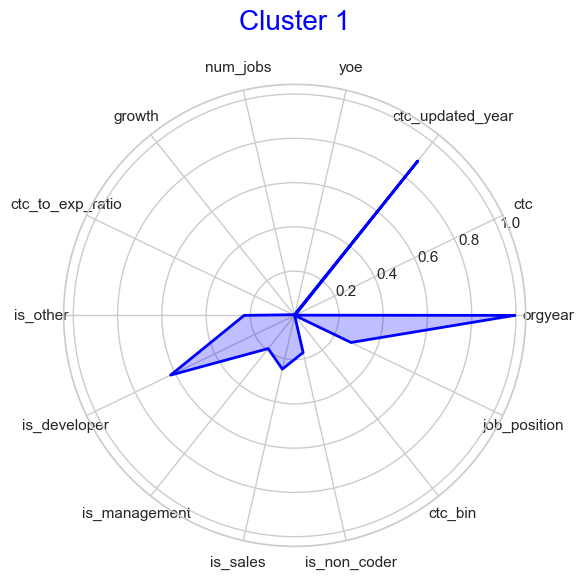

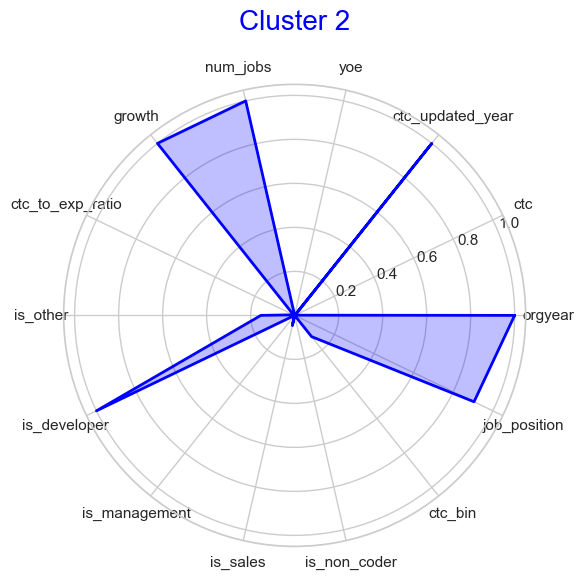

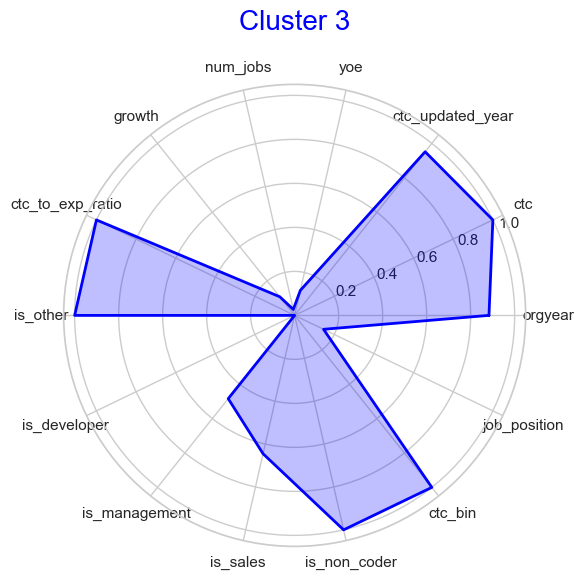

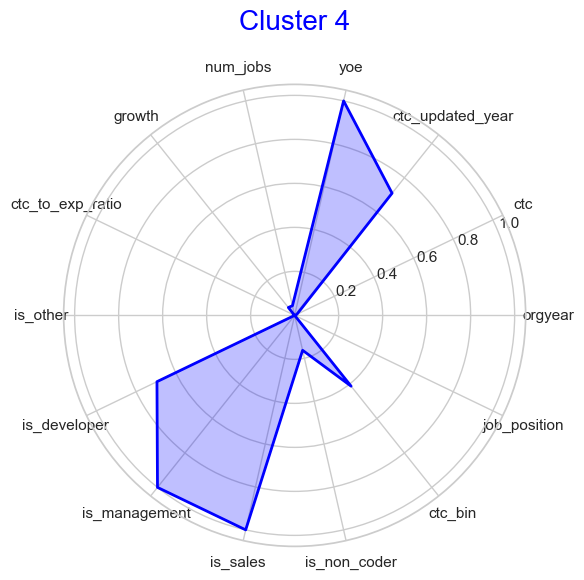

In [234]:
for cluster in range(cluster_means.shape[0]):
    create_polar_plot(normalized_means[cluster], features, cluster)

**Combined Polar Plot**

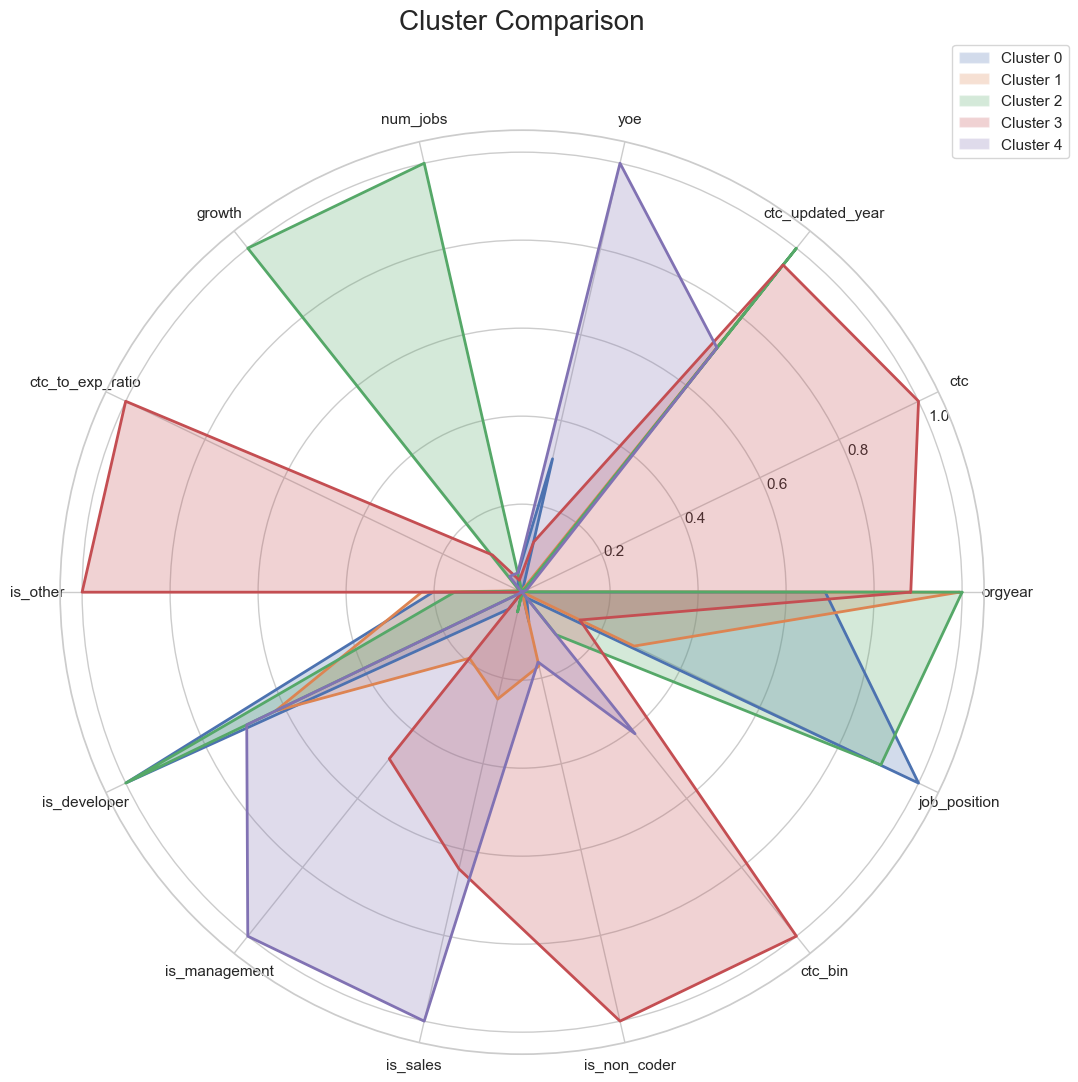

In [235]:
cluster_labels = df["y_kmeans"].unique().to_list()
create_combined_polar_plot(normalized_means, features, cluster_labels)

### Cluster analysis

**Cluster 0**  
Candidates in this cluster have  lower experience. Also they belong developers category

**Cluster 1**  
Candites in this cluster belong to the management and sales category and have higher experience.

**Cluster 2**  
Candidates in this cluster have switched multiple times and had huge growth in package.

**Cluster 3**  
Candidates in this cluster have higher ctc and belong to the non coder category.

**Cluster 4**  
Candidates in this cluster have higher experience and belong to management category along with technical skills.

In [29]:
X_embedded_tsne = umap.UMAP().fit_transform(X)

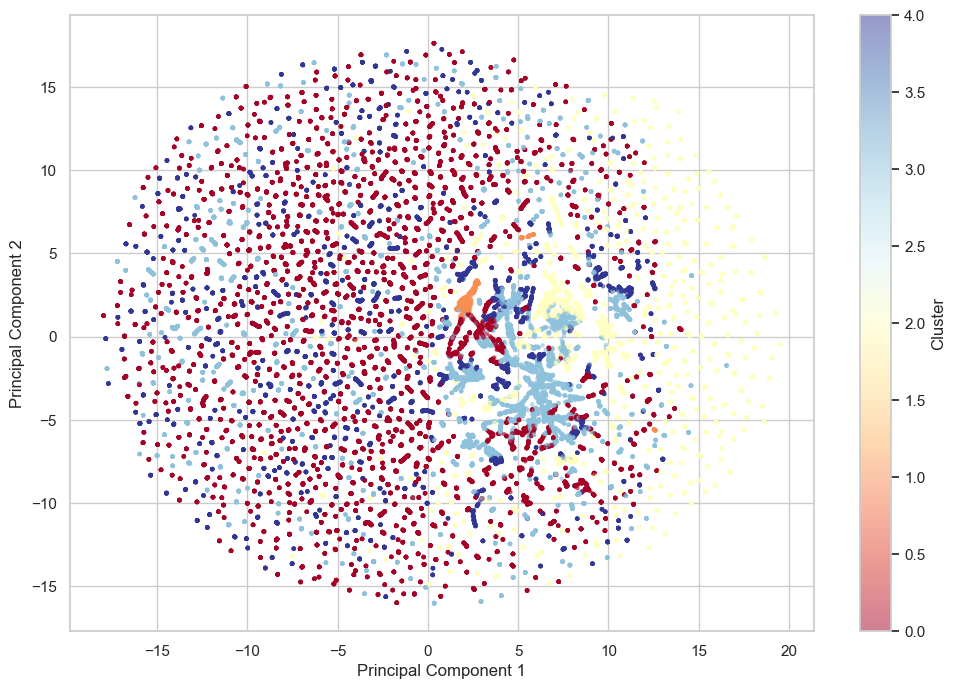

In [237]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], c=y_kmeans, s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

## Hierarchical Clustering

In [3]:
X_embedded_pca = PCA(n_components=8).fit_transform(X)

In [4]:
sample = pd.DataFrame(X_embedded_pca).sample(frac=0.9, random_state=42)

In [5]:
sample_hc = X.loc[sample.index]

In [6]:
sample_hc

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
22086  0.343684 -0.173391         -0.363565 -0.343684 -0.339155 -0.013919   
34847  0.576010 -0.117670          1.123165 -0.576010 -0.339155 -0.013919   
40754  0.576010 -0.196794         -0.363565 -0.576010 -0.339155 -0.013919   
30258 -0.120969 -0.180078         -2.593659  0.120969 -0.339155 -0.013919   
8006   0.808337 -0.154287          1.123165 -0.808337  1.926407 -0.013919   
...         ...       ...               ...       ...       ...       ...   
30453  0.343684 -0.128814         -0.363565 -0.343684 -0.339155 -0.013919   
59128  0.808337 -0.141550          1.123165 -0.808337 -0.339155 -0.013919   
30257 -0.120969 -0.074685         -2.593659  0.120969 -0.339155 -0.013919   
35595  0.343684 -0.189312         -1.106929 -0.343684 -0.339155 -0.013919   
22164  0.576010 -0.046028          1.123165 -0.576010 -0.339155 -0.013919   

       ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
22086         -0.125601         0             1              0         0   
34847         -0.079277         0             0              1         1   
40754         -0.140672         1             0              0         0   
30258         -0.132704         0             1              0         0   
8006          -0.099351         1             0              0         0   
...                 ...       ...           ...            ...       ...   
30453         -0.096777         0             1              0         0   
59128         -0.086998         0             1              0         0   
30257         -0.081593         0             0              1         1   
35595         -0.135896         0             1              0         0   
22164         -0.023688         0             1              0         0   

       is_non_coder   ctc_bin  job_position  
22086             0 -1.263878     -0.862877  
34847             0 -0.428769     -1.269674  
40754             1 -1.263878     -0.164300  
30258             0 -1.263878     -0.632186  
8006              1 -1.263878     -0.164300  
...             ...       ...           ...  
30453             0 -0.428769     -1.121263  
59128             0 -0.428769     -0.952538  
30257             1  0.406340     -1.230215  
35595             0 -1.263878      0.262518  
22164             0  1.241448     -0.862877  

[58298 rows x 14 columns]

In [7]:
%%time
Z = fastcluster.linkage(sample, method='ward')

CPU times: user 3min 33s, sys: 9min 3s, total: 12min 36s
Wall time: 22min 46s


In [13]:
import pickle
# with open("../models/hierarchical_clustering.pkl", "wb") as f:
#     pickle.dump(Z, f)

with open("../models/hierarchical_clustering.pkl", "rb") as f:
    Z = pickle.load(f)

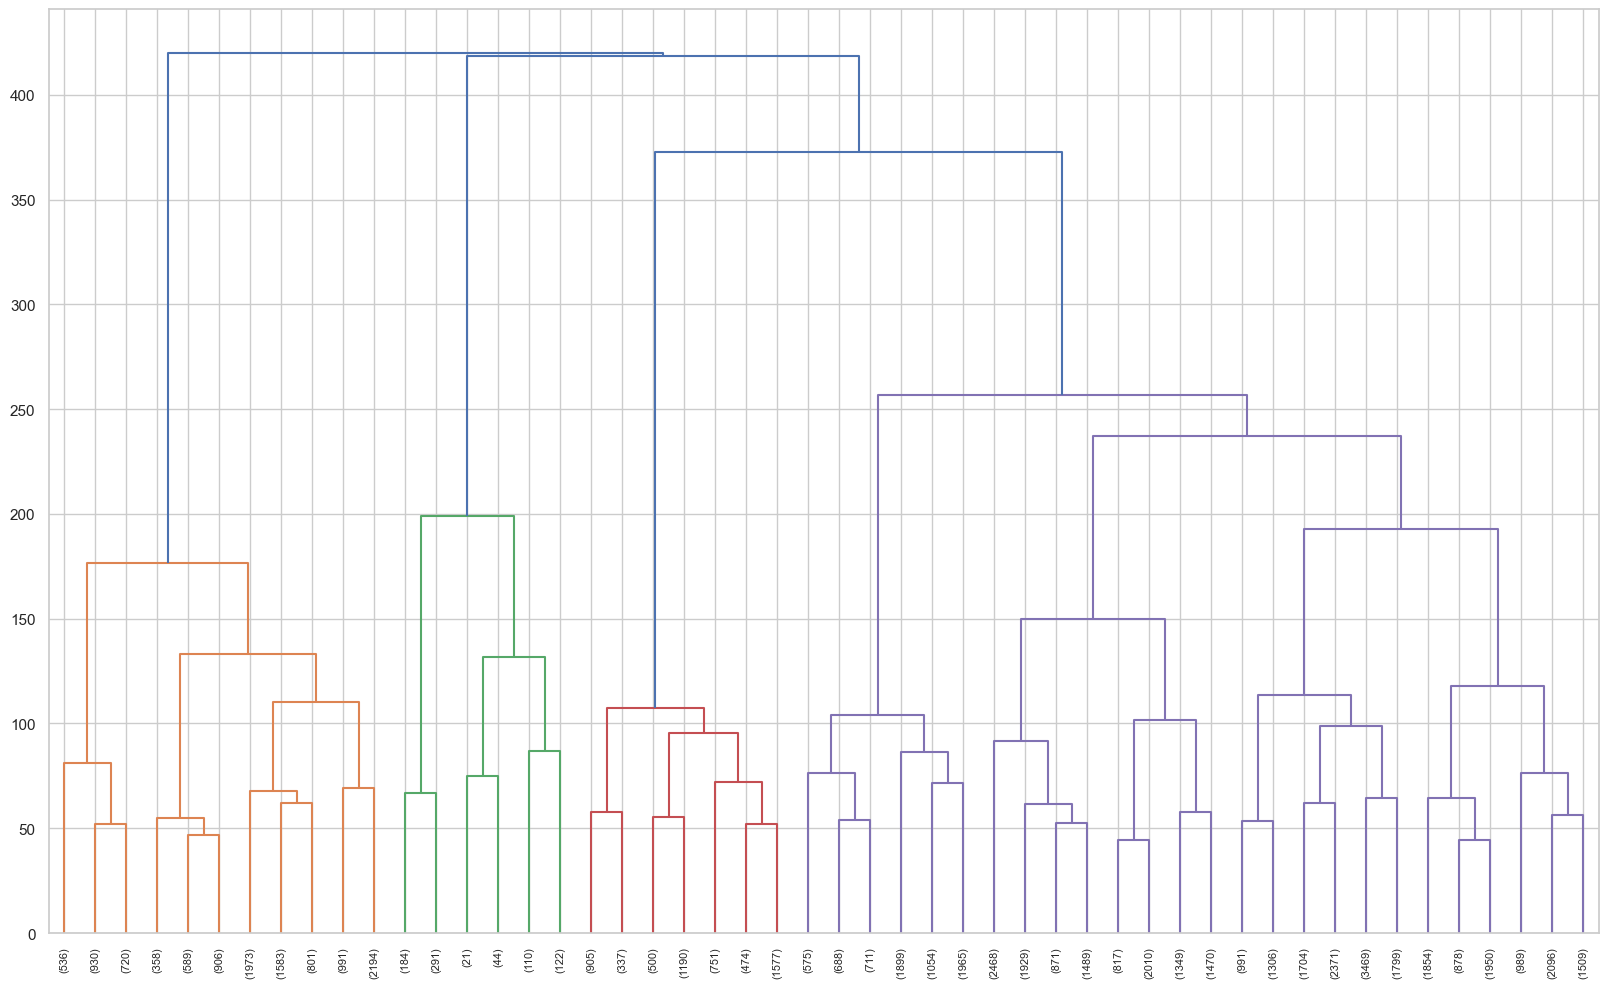

In [9]:
fig, ax = plt.subplots(figsize=(20, 12))
dendrogram( Z, truncate_mode='lastp', p=50);

In [14]:
sample_hc["cluster"] = fcluster(Z, 5, criterion='maxclust')

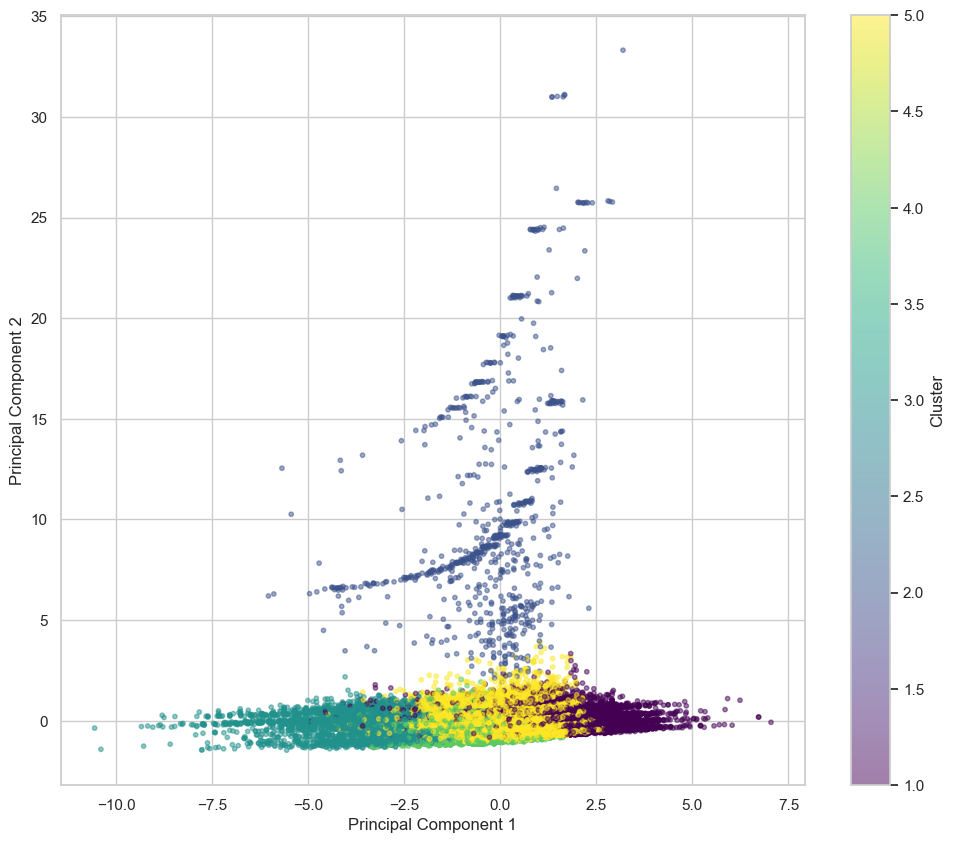

In [12]:
plt.figure(figsize=(12, 10))
scatter=plt.scatter(sample.iloc[:, 0], sample.iloc[:, 1], c=sample_hc["cluster"], s=10, cmap='viridis', alpha=0.5 )
# add legend
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

In [30]:
X_embedded_tsne = umap.UMAP().fit_transform(sample)

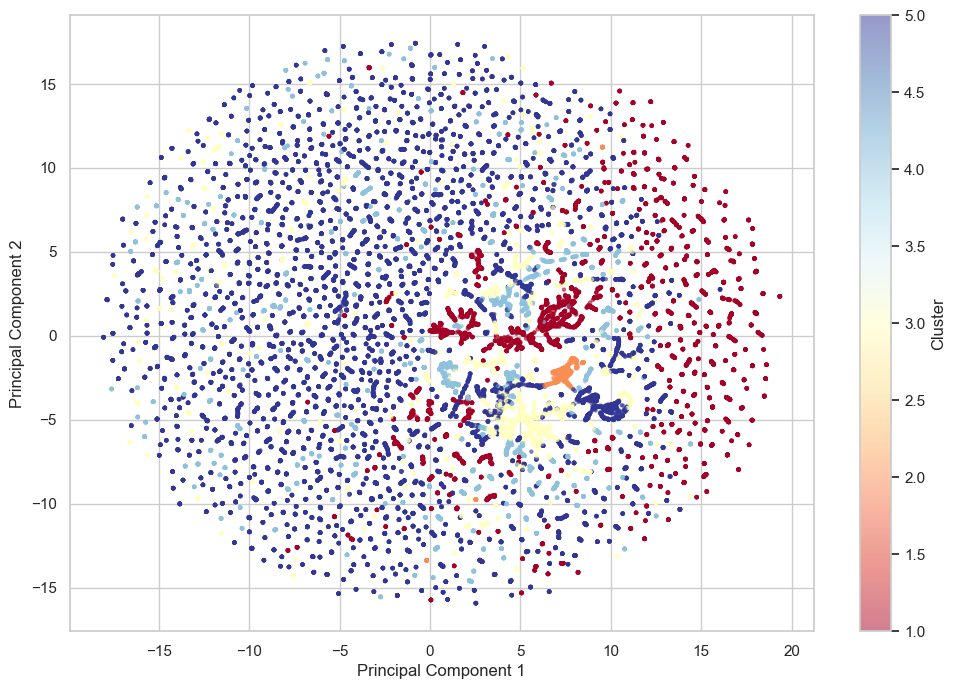

In [31]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], c=sample_hc["cluster"] , s=5, cmap='RdYlBu', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show();

In [18]:
cluster_means = sample_hc.groupby("cluster").mean()
scaler = MinMaxScaler()
normalized_means = scaler.fit_transform(cluster_means)
features =cluster_means.columns.to_list()

In [23]:
cluster_means

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
cluster                                                                       
1        0.273551 -0.064851          0.564342 -0.273551  2.519354  0.064651   
2        0.109853  8.087376          0.400021 -0.109853 -0.245246  0.001319   
3       -2.559585  0.003628         -0.363954  2.559585 -0.322561 -0.013919   
4       -0.310585 -0.086293         -2.179157  0.310585 -0.138963 -0.010967   
5        0.073830 -0.075520          0.141434 -0.073830 -0.339155 -0.013919   

         ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
cluster                                                                      
1               -0.049069  0.099042      0.826008       0.060357  0.079009   
2                6.560484  0.303109      0.553109       0.148964  0.181347   
3               -0.097548  0.034705      0.783572       0.372864  0.328392   
4               -0.090778  0.165264      0.722867       0.102438  0.094312   
5               -0.060270  0.098652      0.769381       0.101474  0.114109   

         is_non_coder   ctc_bin  job_position  
cluster                                        
1            0.116657  0.227506      0.105622  
2            0.356218  2.076557     -0.348436  
3            0.117021  0.700973     -0.480073  
4            0.200087 -0.002248     -0.330149  
5            0.131727  0.049653     -0.172190

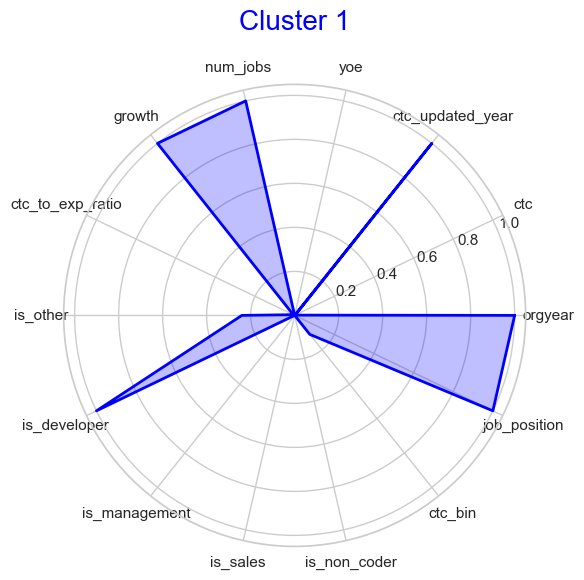

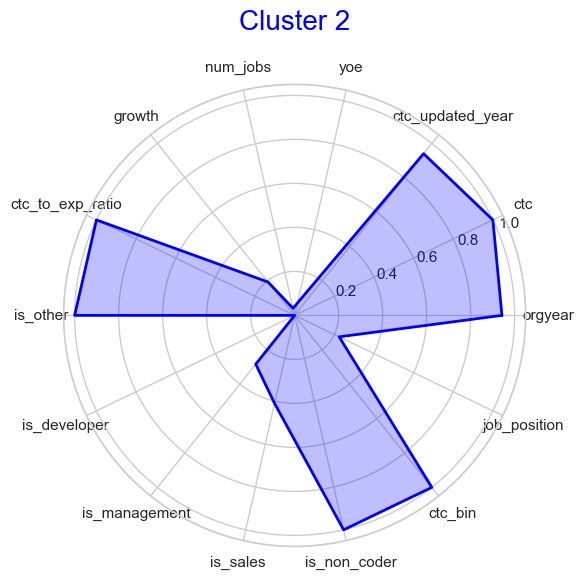

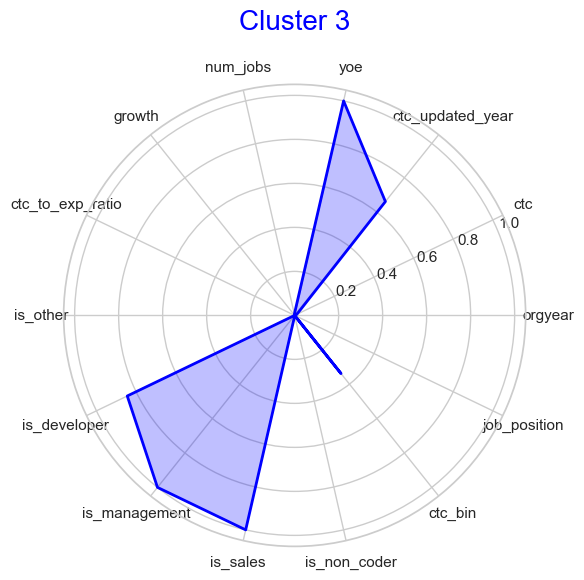

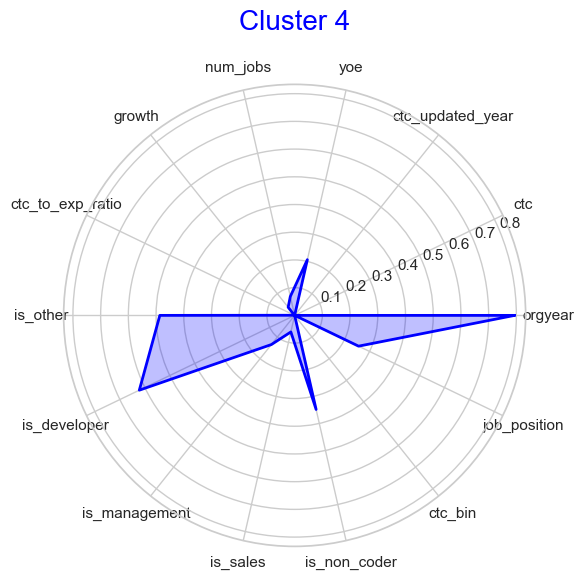

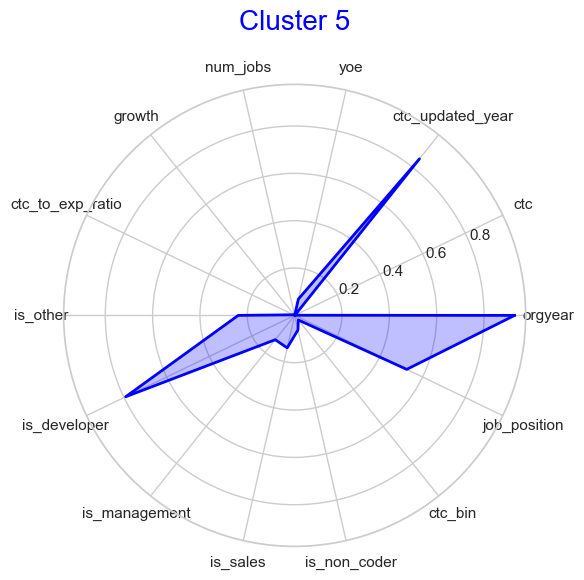

In [22]:
for cluster in range(cluster_means.shape[0]):
    create_polar_plot(normalized_means[cluster], features, cluster+1)

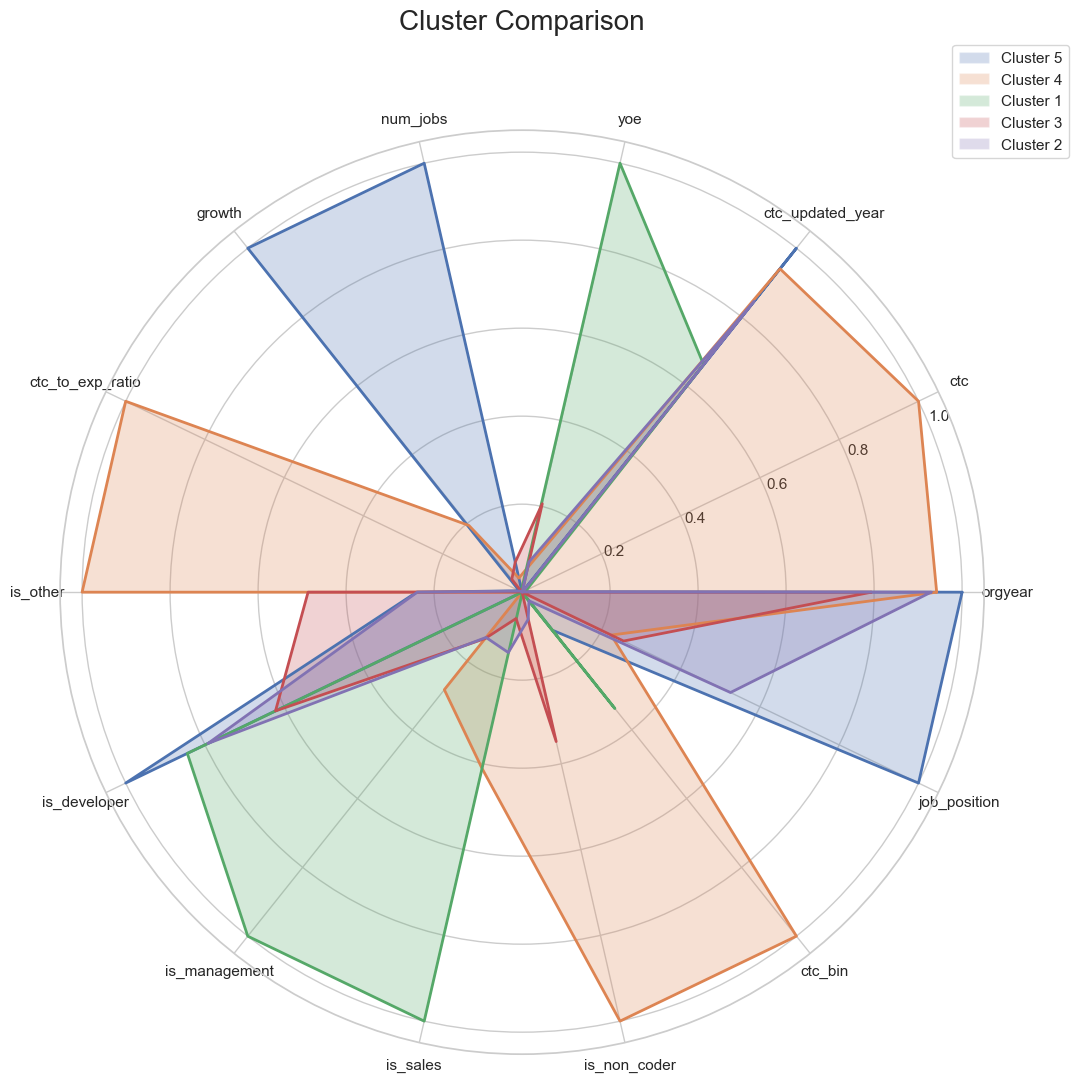

In [19]:
cluster_labels = sample_hc["cluster"].unique()
create_combined_polar_plot(normalized_means, features, cluster_labels)

### Cluster Analysis

**Cluster 0**  
Candidates in this cluster belong to developers category, and have higher number of job switches.

**Cluster 1**  
Candidates in this cluster belong to the non coder category with high ctc

**Cluster 2**  
Candidates in this cluster have higher experience and belong to management category along with technical skills.

**Cluster 3**  
Candidates in this cluster have  lower experience. Also they belong developers category

**Cluster 4**    
Candidates in this cluster have recently got hike and belong to developer category


In [15]:
sample_hc.to_parquet("../data/processed/sample_hc.parquet")

In [16]:
sample_hc

orgyear       ctc  ctc_updated_year       yoe  num_jobs    growth  \
22086  0.343684 -0.173391         -0.363565 -0.343684 -0.339155 -0.013919   
34847  0.576010 -0.117670          1.123165 -0.576010 -0.339155 -0.013919   
40754  0.576010 -0.196794         -0.363565 -0.576010 -0.339155 -0.013919   
30258 -0.120969 -0.180078         -2.593659  0.120969 -0.339155 -0.013919   
8006   0.808337 -0.154287          1.123165 -0.808337  1.926407 -0.013919   
...         ...       ...               ...       ...       ...       ...   
30453  0.343684 -0.128814         -0.363565 -0.343684 -0.339155 -0.013919   
59128  0.808337 -0.141550          1.123165 -0.808337 -0.339155 -0.013919   
30257 -0.120969 -0.074685         -2.593659  0.120969 -0.339155 -0.013919   
35595  0.343684 -0.189312         -1.106929 -0.343684 -0.339155 -0.013919   
22164  0.576010 -0.046028          1.123165 -0.576010 -0.339155 -0.013919   

       ctc_to_exp_ratio  is_other  is_developer  is_management  is_sales  \
22086         -0.125601         0             1              0         0   
34847         -0.079277         0             0              1         1   
40754         -0.140672         1             0              0         0   
30258         -0.132704         0             1              0         0   
8006          -0.099351         1             0              0         0   
...                 ...       ...           ...            ...       ...   
30453         -0.096777         0             1              0         0   
59128         -0.086998         0             1              0         0   
30257         -0.081593         0             0              1         1   
35595         -0.135896         0             1              0         0   
22164         -0.023688         0             1              0         0   

       is_non_coder   ctc_bin  job_position  cluster  
22086             0 -1.263878     -0.862877        5  
34847             0 -0.428769     -1.269674        5  
40754             1 -1.263878     -0.164300        5  
30258             0 -1.263878     -0.632186        4  
8006              1 -1.263878     -0.164300        1  
...             ...       ...           ...      ...  
30453             0 -0.428769     -1.121263        5  
59128             0 -0.428769     -0.952538        5  
30257             1  0.406340     -1.230215        4  
35595             0 -1.263878      0.262518        5  
22164             0  1.241448     -0.862877        5  

[58298 rows x 15 columns]

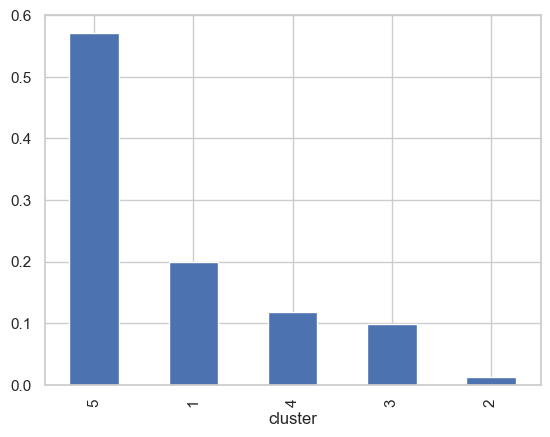

In [36]:
sample_hc["cluster"].value_counts(normalize=True).plot(kind="bar");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that cluster 5 containing developers has the highest count and cluster 2 containing non coders has the lowest count.
- More than 50% of the candidates belong to cluster 5.

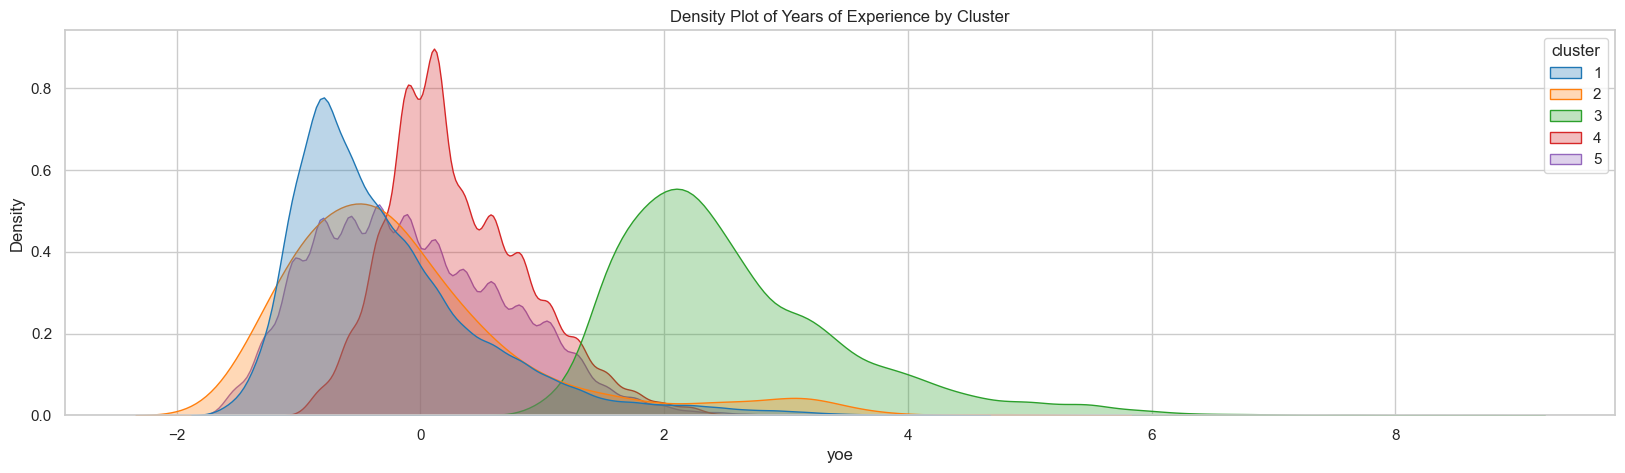

In [50]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=sample_hc, x="yoe", hue="cluster", cbar=True, fill=True, common_norm=False, alpha=0.3,  palette="tab10");
plt.title("Density Plot of Years of Experience by Cluster");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Cluster 3 containing management employees have higher experience

# Insights and Recomendations


- There are 5 clusters in the dataset.
- Majority of the candidates belong to cluster 5 which contains developers amounting to more than 50% of the candidates.
- Company should focus on these candidates as they are the majority.
- Company should push junior candidates towards backend developement roles as they have the highest average CTC
- Company should push mid level candidates towards management roles. 
- Alternatively if mid level candidates are very good at technical skills, they can be pushed towards technical management roles.
- There are very few non coders in the dataset.
- Hierarichical clustering seems to be a better fit for this dataset as it is able to capture the clusters better than K-means clustering provided the dataset is small
- If dataset is large then K-means clustering is a better fit as it is faster than Hierarchical clustering.